In [1]:
import dask.dataframe as dd
import dask
from scipy import stats
import os
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import shutil
import glob
#from adjustText import adjust_text
from gimmemotifs.preprocessing import combine_peaks
from gimmemotifs.preprocessing import coverage_table
from pathlib import Path
import qnorm
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score
from importlib import reload  
#from statannot import add_stat_annotation
%matplotlib inline
%load_ext autoreload
%autoreload 2

os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts")
from Python_scripts import distance_weight
genome = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/hg38/hg38.fa"


Matplotlib is building the font cache; this may take a moment.


In [2]:
import scipy
import scipy.cluster.hierarchy as sch
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    https://wil.yegelwel.com/cluster-correlation-matrix/#:~:text=Cluster%20a%20Correlation%20Matrix%20%28in%20python%29%20Below%20is,that%20looks%20like%3A%20Into%20one%20that%20looks%20like%3A
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

# def multiple_testing_correction(pvalues, correction_type="FDR"):
#     """
#     Consistent with R - print
#     correct_pvalues_for_multiple_testing([0.0, 0.01, 0.029, 0.03, 0.031, 0.05,
#                                           0.069, 0.07, 0.071, 0.09, 0.1])
#                                           https://github.com/CoBiG2/cobig_misc_scripts
#     """
#     from numpy import array, empty
#     pvalues = array(pvalues)
#     sample_size = pvalues.shape[0]
#     qvalues = empty(sample_size)
#     if correction_type == "Bonferroni":
#         # Bonferroni correction
#         qvalues = sample_size * pvalues
#     elif correction_type == "Bonferroni-Holm":
#         # Bonferroni-Holm correction
#         values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
#         values.sort()
#         for rank, vals in enumerate(values):
#             pvalue, i = vals
#             qvalues[i] = (sample_size-rank) * pvalue
#     elif correction_type == "FDR":
#         # Benjamini-Hochberg, AKA - FDR test
#         values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
#         values.sort()
#         values.reverse()
#         new_values = []
#         for i, vals in enumerate(values):
#             rank = sample_size - i
#             pvalue, index = vals
#             new_values.append((sample_size/rank) * pvalue)
#         for i in range(0, int(sample_size)-1):
#             if new_values[i] < new_values[i+1]:
#                 new_values[i+1] = new_values[i]
#         for i, vals in enumerate(values):
#             pvalue, index = vals
#             qvalues[index] = new_values[i]
#     return qvalues

import statsmodels.stats.multitest as multi

In [3]:
output_dir = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10'
Path(f"{output_dir}").mkdir(parents=True, exist_ok=True)       
sample_data_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/Cell_type_files.tsv'
#load the genome info
genome_path_size = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/genomes/hg38/hg38.fa.sizes"
genome_path = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/genomes/hg38/hg38.fa"
data_type_list = ['both','only_ATAC','Remap_H3K27ac','only_H3K27ac']
data_type_list = ['both']

In [ ]:
#Lets loop over all the comparisons Ananse needs to make:
sample_data = pd.read_table(sample_data_file, 
                            sep = '\t', comment = '#')
#sample_data = sample_data.iloc[[0,1],:]
sample_data

In [ ]:
#Lets merge all the peaks, and only the KC-LSC peaks (for a more specific peakset for the KC-LSC comparison)
all_peakfiles = []
KC_LSC_peakfiles = []
LSC_peakfiles = []

for index, cell_type in sample_data.iterrows():
    cell_id = sample_data.iloc[index,0]
    all_peakfiles.extend(sample_data.Accesibility_peakfiles[index].split(' '))
    if ((cell_id =='KCs') | (cell_id == 'LSCs')):
        KC_LSC_peakfiles.extend(sample_data.Accesibility_peakfiles[index].split(' '))
    if cell_id == 'LSCs':
        LSC_peakfiles.extend(sample_data.Accesibility_peakfiles[index].split(' '))

for peak_file_list, output_files in zip([all_peakfiles,KC_LSC_peakfiles, LSC_peakfiles],[f'{output_dir}/all_peaks.tsv',f'{output_dir}/KC_LSC_peaks.tsv',f'{output_dir}/LSC_peaks.tsv']):
    if not os.path.exists(f"{output_files}"): 
        all_peaks_merged = combine_peaks(peak_file_list,
                                         genome_path_size,
                                         int(200),
                                         True)
        all_peaks_merged = all_peaks_merged[~all_peaks_merged.chrom.str.contains("GL|Un|KI|MT|X|Y")]
        #extend each summit to 200bp
        all_peaks_merged.start = all_peaks_merged.start.astype(int) - 100
        all_peaks_merged.end = all_peaks_merged.end.astype(int) + 100

        all_peaks_merged.to_csv(
            output_files,
            sep="\t",
            header=False,
            index=False,
        )

# Scan for motifs 
in the peak regions once, and use the result for all subsequent ananse runs

In [ ]:
gimmescanfile = f'{output_dir}/all_peaks_scanned.pfmscores'
if not os.path.exists(f"{gimmescanfile}"): 
    sp.check_call(f'gimme scan '
                  f'-Tz --gc '
                  f'-N 12 '
                  f'-g {genome} '
                  f'{output_dir}/{sample_data.Merged_peakfiles[index]} '
                  f'> {gimmescanfile} '
                  f'2> {output_dir}/motif_scanning_log.txt',shell = True)

Also, lets map the ATAC peak regions to the closest gene for target gene analysis way later!

In [ ]:
# regions2genes = F"{output_dir}/all_peaks_2_genes.tsv"
# if not os.path.exists(f"{regions2genes}"): 
#     sp.check_call(f
#                   f'{output_dir}/{sample_data.Merged_peakfiles[index]} '
#                   f'> {gimmescanfile} '
#                   f'2> {output_dir}/motif_scanning_log.txt',shell = True)

In [ ]:
#F"{output_dir}/{sample_data.Merged_peakfiles[index]}"

In [ ]:
#F"{output_dir}/peaks_2_genes.tsv"

# Ananse binding

In [ ]:
i = 0
for jacard_cutoff in [0,0.1,0.2,0.4,0.6,0.8,1.0]:
    for index, cell_type in sample_data.iterrows():
        cell_id = sample_data.iloc[index,0]
        print(cell_id)
        for binding_mode in data_type_list:
            print(f'{binding_mode}')
            print(f'reseting gimme motifs cache')
            shutil.rmtree("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/.cache/gimmemotifs", ignore_errors=True)
            shutil.rmtree("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/.cache/genomepy", ignore_errors=True)
            #make output dir
            Path(f"{output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}").mkdir(parents=True, exist_ok=True)       

            ATAC_bamfiles = str(sample_data.Accesibility_BAMfiles[index])
            H3K27ac_bamfiles = str(sample_data.H3K27ac_BAMfiles[index])

            if binding_mode == 'both':
                if not os.path.exists(f"{output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/binding.h5"): 
                    print(f'running ananse binding for celltype {cell_id} using the {binding_mode} datatypes with the ATAC merged peaks of {sample_data.Merged_peakfiles[index]}')
                    sp.check_call(f'nice -15 ananse binding '
                        f'-g hg38 '
                        f'--pfmscorefile {gimmescanfile} '
                        f'-H {H3K27ac_bamfiles} '
                        f'-A {ATAC_bamfiles} '
                        f'-r {output_dir}/{sample_data.Merged_peakfiles[index]} '
                        f'-n 12 '
                        f'--pfmscorefile {gimmescanfile} '
                        f'--jaccard-cutoff {jacard_cutoff} ' 
                        f'--outdir {output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/ '
                        f'2> {output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/ananse_binding_log.txt',shell = True)   

            if binding_mode == 'only_ATAC':
                if not os.path.exists(f"{output_dir}/{binding_mode}/{cell_id}/binding.h5"): 
                    print(f'running ananse binding for celltype {cell_id} using the {binding_mode} datatypes with the ATAC merged peaks of {sample_data.Merged_peakfiles[index]}')
                    sp.check_call(f'nice -15 ananse binding '
                        f'-g hg38 '
                        f'-A {ATAC_bamfiles} '
                        f'-r {output_dir}/{sample_data.Merged_peakfiles[index]} '
                        f'-n 12 '
                        f'--pfmscorefile {gimmescanfile} '
                        f'--jaccard-cutoff 0.2 ' 
                        f'--outdir {output_dir}/{binding_mode}/{cell_id} '
                        f'2> {output_dir}/{binding_mode}/{cell_id}/ananse_binding_log.txt',shell = True)   

            if binding_mode == 'only_H3K27ac':
                if not os.path.exists(f"{output_dir}/{binding_mode}/{cell_id}/binding.h5"): 
                    print(f'running ananse binding for celltype {cell_id} using the {binding_mode} datatypes with the ATAC merged peaks of {sample_data.Merged_peakfiles[index]}')
                    sp.check_call(f'nice -15 ananse binding '
                        f'-g hg38 '
                        f'-H {H3K27ac_bamfiles} '
                        f'-r {output_dir}/{sample_data.Merged_peakfiles[index]} '
                        f'-n 12 '
                        f'--pfmscorefile {gimmescanfile} '
                        f'--jaccard-cutoff 0.2 ' 
                        f'--outdir {output_dir}/{binding_mode}/{cell_id} '
                        f'2> {output_dir}/{binding_mode}/{cell_id}/ananse_binding_log.txt',shell = True)   


            if binding_mode == 'Remap_H3K27ac':
                if not os.path.exists(f"{output_dir}/{binding_mode}/{cell_id}/binding.h5"): 
                    print(f'running ananse binding for celltype {cell_id} using the {binding_mode} datatypes with Remap peaks')
                    sp.check_call(f'nice -15 ananse binding '
                        f'-g hg38 '
                        f'-H {H3K27ac_bamfiles} '
                        f'-R /ceph/rimlsfnwi/data/moldevbio/share_moldevbio/heeringen/ananse/models/20200223.trained/ '
                        f'-n 12 '
                        f'--pfmscorefile {gimmescanfile} '
                        f'--jaccard-cutoff 0.2 ' 
                        f'--outdir {output_dir}/{binding_mode}/{cell_id} '
                        f'2> {output_dir}/{binding_mode}/{cell_id}/ananse_binding_log.txt',shell = True)   

# Ananse network

Generate GRN's based on the binding.tsv output and RNAseq expression

In [ ]:
#make one TPM file per sample using the big count matrix containing all samples
ensembl2hugo =  pd.read_table('/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/gene_id2name.tsv',sep = '\t', comment ='_',names = ['ensembl','HUGO'])
for index, cell_type in sample_data.iterrows():
    for binding_mode in data_type_list:
        cell_id = sample_data.iloc[index,0]
        TPM_matrix_file = sample_data.TPM_matrix[index]
        TPM_matrix = pd.read_table(TPM_matrix_file,sep = '\t',index_col = 0)
        #check to see if the gene IDs need to be converted (for bulk, not for single cell)
        if bool(sample_data.rename_TPM_gene_names[index]):
            #convert matrix to gene name
            hugo_tpm_matrix = TPM_matrix.merge(ensembl2hugo, left_index = True, right_on = 'ensembl', how = 'inner')
            hugo_tpm_matrix.index = hugo_tpm_matrix.HUGO
            hugo_tpm_matrix = hugo_tpm_matrix.drop_duplicates()
            hugo_tpm_matrix = hugo_tpm_matrix.drop_duplicates(subset='HUGO', keep="first")
            hugo_tpm_matrix = hugo_tpm_matrix.drop(['ensembl','HUGO'], axis = 1)
        else:
            hugo_tpm_matrix = TPM_matrix.copy()
        TPM_files = sample_data.TPM_names[index].split(' ')
        Path(f"{output_dir}/{binding_mode}/{cell_id}/TPM_files/").mkdir(parents=True, exist_ok=True) 
        for sample in TPM_files:
            sample_matrix = hugo_tpm_matrix[sample]
            sample_matrix = pd.DataFrame(sample_matrix)
            sample_matrix[['target_id']] = sample_matrix.index
            sample_matrix[['tpm']] = sample_matrix[[sample]]
            sample_matrix[['target_id','tpm']]
            #save sample TPM file
            sample_matrix[['target_id','tpm']].to_csv(f"{output_dir}/{binding_mode}/{cell_id}/TPM_files/FPM_{sample}.tsv", sep = '\t', index = False, header = True)


In [ ]:
for jacard_cutoff in [0.2]:
    for index, cell_type in sample_data.iterrows():
        cell_id = sample_data.iloc[index,0]
        print(cell_id)
        for binding_mode in data_type_list:
            for weight_modus in ['include-promoter', 'exclude-promoter']:
                binding_file = f"{output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/binding.h5"
                print(f'running ananse binding using the enhancer file {binding_file} with {weight_modus}')
                TPM_files = glob.glob(f"{output_dir}/{binding_mode}/{cell_id}/TPM_files/*")
                TPM_files = ' '.join(TPM_files)
                if not os.path.exists(f"{output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/full_network_{weight_modus}.txt"):
                    print(f'and the TPM files: {TPM_files}')
                    print(f'and the output file full_network_{weight_modus}.txt')
                    sp.check_call(f'nice -15 ananse network '
                        f'-e {TPM_files} '
                        f'-b {binding_file} '
                        f'-o {output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/full_network_{weight_modus}.txt '
                        f'-g hg38 '
                        f'--{weight_modus} --include-enhancer --full-output '
                        f'-n 1 '
                        f'2> {output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/ananse_network_{weight_modus}_log.txt',shell = True)

# Ananse Influence

Lets finally run Ananse influence to predict key TFs that differ between cell types.
Each comparison we want to run should be added to the file:  
"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/influence_comparisons.csv" 

In [ ]:
#Lets first generate a matrix with all the different comparisons needed 
sample_data = pd.read_table(sample_data_file, 
                            sep = '\t', comment ='#')
ensembl2hugo =  pd.read_table('/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/gene_id2name.tsv',sep = '\t', comment ='_',names = ['ensembl','HUGO'])

for jacard_cutoff in [0.2]:
    for index, cell_type in sample_data.iterrows():
        for binding_mode in data_type_list:
            comparisons = sample_data.compare_with[index]
            cell_id = sample_data.iloc[index,0]
            #get the count data files for the source cell type
            count_files_source_cell_type = sample_data.TPM_names[index].split(' ')
            if not comparisons != comparisons: #do stuff if there is a string in the comparisons column
                for comparison in comparisons.split(' '):
                    #get the count data files for the target cell type
                    target_data = sample_data.loc[sample_data['cell_type'] == comparison]
                    target_data = target_data.reset_index(drop=True)
                    count_files_target_cell_type = target_data.TPM_names[0].split(' ')
                    source_count_matrix = sample_data.count_table_files[index]
                    target_count_matrix = target_data.count_table_files[0]
                    source_matrix_rename = sample_data.rename_TPM_gene_names[index]
                    target_matrix_rename = target_data.rename_TPM_gene_names[0]
                    #lets run deseq between the sample comparisons 
                    comp_name = f'{cell_id}_to_{comparison}'
                    print(f'comparing {comp_name}')
                    if not os.path.exists(f"{output_dir}/{binding_mode}/influence/{comp_name}"):
                        Path(f"{output_dir}/{binding_mode}/influence/{comp_name}").mkdir(parents=True, exist_ok=True)
                    for network_type, rename_network, count_matrix in zip(['source','target'],
                            [source_matrix_rename,target_matrix_rename],
                            [source_count_matrix,target_count_matrix]):
                       # print(f'{network_type} {rename_network} {count_matrix}')
                        count_matrix = pd.read_table(count_matrix, sep = '\t',index_col = 0, header = 0)
                        if rename_network:
                            print(f'renaming count matrix {network_type}')
                            count_matrix = count_matrix.merge(ensembl2hugo, left_index = True, right_on = 'ensembl', how = 'inner')
                            count_matrix.index = count_matrix.HUGO
                            count_matrix = count_matrix.drop_duplicates()
                            count_matrix = count_matrix.drop_duplicates(subset='HUGO', keep="first")
                            count_matrix = count_matrix.drop(['ensembl','HUGO'], axis = 1)

                        count_matrix.to_csv(f"{output_dir}/{binding_mode}/influence/{comp_name}/{network_type}_count_matrix.tsv", sep = '\t')

                    #if source and target matrix are different, merge them 
                    if source_count_matrix != target_count_matrix:
                        print('merging counttables source and target cell type')
                        sourcecount_matrix =  pd.read_table(f"{output_dir}/{binding_mode}/influence/{comp_name}/source_count_matrix.tsv", sep = '\t', index_col = 0, header = 0)
                        target_count_matrix =  pd.read_table(f"{output_dir}/{binding_mode}/influence/{comp_name}/target_count_matrix.tsv", sep = '\t', index_col = 0, header = 0)
                        final_matrix = sourcecount_matrix.merge(target_count_matrix, left_index = True, right_index = True )
                    else: final_matrix =  pd.read_table(f"{output_dir}/{binding_mode}/influence/{comp_name}/source_count_matrix.tsv", sep = '\t', index_col = 0, header = 0)
                    #subset the final counttable to only include the relevant samples
                    final_matrix = final_matrix[(count_files_source_cell_type + count_files_target_cell_type)]
                    final_matrix.index.names = ['HUGO']
                    final_matrix.to_csv(f"{output_dir}/{binding_mode}/influence/{comp_name}/count_matrix.tsv", sep = '\t', index = True, header = True)

                    #make a sample file for deseq2 
                    sample_names = (count_files_source_cell_type + count_files_target_cell_type)
                    annotation = ["source"] * len(count_files_source_cell_type) + ["target"] * len(count_files_target_cell_type)
                    data= {'samples':sample_names, 'condition':annotation}
                    sample_info_df = pd.DataFrame(data)
                    sample_info_df.to_csv(f"{output_dir}/{binding_mode}/influence/{comp_name}/sample_info.tsv", sep = ',', index = False, header = True)
                    #run Deseq2 
                    if not os.path.exists(f"{output_dir}/{binding_mode}/influence/{comp_name}/DEG.tsv"):
                        print('running Deseq2')
                        sp.check_call(
                            f'nice -5 Rscript --vanilla '
                            f'/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/RunDeseq2.R '
                            f'{output_dir}/{binding_mode}/influence/{comp_name}/count_matrix.tsv '
                            f'{output_dir}/{binding_mode}/influence/{comp_name}/sample_info.tsv '
                            f'{output_dir}/{binding_mode}/influence/{comp_name}/DEGs.csv '
                            f'2> {output_dir}/{binding_mode}/influence/{comp_name}/deseq2log.txt',
                            shell = True)

                        DEG_table = pd.read_table(f'{output_dir}/{binding_mode}/influence/{comp_name}/DEGs.csv', 
                                sep = ',', comment = '#')
                        DEG_table['resid'] = DEG_table['region']
                        DEG_table = DEG_table.dropna()
                        DEG_table[['resid','log2FoldChange','padj']].to_csv(f'{output_dir}/{binding_mode}/influence/{comp_name}/DEG.tsv', sep = '\t', index = False, header = True)
                    DEG_file = f'{output_dir}/{binding_mode}/influence/{comp_name}/DEG.tsv'

                    for weight_modus in ['include-promoter']:
                        for n_edges in [500000]:
                            source_network = f'{output_dir}/{binding_mode}/{cell_id}/{jacard_cutoff}/full_network_{weight_modus}.txt'
                            target_network = f'{output_dir}/{binding_mode}/{comparison}/{jacard_cutoff}/full_network_{weight_modus}.txt'
                            influence_output_name = f'{output_dir}/{binding_mode}/influence/{comp_name}/{weight_modus}/{n_edges}/{jacard_cutoff}/'
                            if not os.path.exists(f"{influence_output_name}"):
                                Path(f"{influence_output_name}").mkdir(parents=True, exist_ok=True)
                            if not os.path.exists(f"{influence_output_name}influence.txt"):
                                print(f'running influence for {comp_name} with the datatype of {binding_mode} and {weight_modus} with nedges of {n_edges}')
                                sp.check_call(f'nice -15 ananse influence '
                                    f'-s {source_network} '
                                    f'-t {target_network} '
                                    f'-d {DEG_file} '
                                    f'--edges {n_edges} '
                                    f'--full-output '
                                    f'--GRNsort-column prob '
                                    f'-o {influence_output_name}influence.txt ' 
                                    f'-n 16 '
                                    f'2> {influence_output_name}log.txt',shell = True)
                            #next lets vizualize the GRN and dotplot files as well
                            #if not os.path.exists(f"{influence_output_name}influence.pdf"):
                            if not os.path.exists(f'{influence_output_name}topTF_GRN.png'):
                                print('vizualizing network')
                                sp.check_call(f'nice -15 ananse plot '
                                    f'-i  {influence_output_name}influence.txt '
                                    f'-o  {influence_output_name} '
                                    f'--diff-network {influence_output_name}influence_diffnetwork.txt '
                                    f'--edge-min 0.05'
                                    f'2> {influence_output_name}log_plot.txt',shell = True)

# ESC - KC - LSC triangle differences

In order to fairly compare ESC 2 KC, ESC 2 LSC, and LSC 2 KC, we need to make some slight alterations. Ananse influence takes the interactions in the top source, and top target network. However since here we have three networks (top ESC, top LSC, and KC) this can lead to discreptancies.

One example is EHF, which is exluded in ESC to KCs, eventhough there are clear differences. There are just 500.000 more striking differences in that analysis.

To combat this we will first generate a set of all top interactions, and input those in the influence function for calculating ESC 2 KC and ESC 2 LSC. Luckely all the important interactions have already been calculated for each comparison, all we need to do is extract them from the generated diffnetworks and rerun influence with all interactions for these cell types.

In [ ]:
all_interactions_set = set()
weight_modus = 'include-promoter'
n_edges = 500000

for jacard_cutoff in [0,0.1,0.2,0.4,0.6,0.8,1.0]:
    interaction_file = f'{output_dir}/{binding_mode}/influence/ESC_KC_LSC_all_{weight_modus}_interactions_{jacard_cutoff}.txt'
    if not os.path.exists(f'{interaction_file}'):
        for comp_name in ['ESCs_to_KCs', 'ESCs_to_LSCs', 'KCs_to_LSCs','LSCs_to_KCs' ]:
            influence_output_name = f'{output_dir}/{binding_mode}/influence/{comp_name}/{weight_modus}/{n_edges}/{jacard_cutoff}/'
            diff_network = f'{influence_output_name}influence_diffnetwork.txt'
            rnet = pd.read_csv(
                    diff_network,
                    sep="\t",
                    dtype="float64",
                    converters={"tf": str,
                               "target": str},
                )
            rnet['tf_target'] = rnet['tf'] + "—" + rnet['target']
            rnet_set = set(rnet['tf_target'])
            all_interactions_set.update(rnet_set)
            print(len(all_interactions_set))

        interaction_file = f'{output_dir}/{binding_mode}/influence/ESC_KC_LSC_all_{weight_modus}_interactions_{jacard_cutoff}.txt'
        interaction_df = pd.DataFrame(data=list(all_interactions_set))
        interaction_df.to_csv(interaction_file, index=False, header = False)

### lets rerun ananse influence this time with the correct interactions for ESC-KC and ESC-LSC

In [ ]:
binding_mode = 'both'

for jacard_cutoff in [0,0.2,0.4]:
    for comp_name,source,target in zip(['ESCs_to_KCs', 'ESCs_to_LSCs','LSCs_to_KCs','KCs_to_LSCs'],
                                       ['ESCs','ESCs','LSCs','KCs'],
                                       ['KCs','LSCs','KCs','LSCs']):
            for weight_modus in ['include-promoter']:
                    interaction_file = f'{output_dir}/{binding_mode}/influence/ESC_KC_LSC_all_{weight_modus}_interactions_{jacard_cutoff}.txt'
                    source_network = f'{output_dir}/{binding_mode}/{source}/{jacard_cutoff}/full_network_{weight_modus}.txt'
                    target_network = f'{output_dir}/{binding_mode}/{target}/{jacard_cutoff}/full_network_{weight_modus}.txt'
                    influence_output_name = f'{output_dir}/{binding_mode}/influence/{comp_name}/{weight_modus}/ESC_KC_LSC_all/{jacard_cutoff}/'
                    if not os.path.exists(f"{influence_output_name}"):
                        Path(f"{influence_output_name}").mkdir(parents=True, exist_ok=True)
                    DEG_file = f'{output_dir}/{binding_mode}/influence/{comp_name}/DEG.tsv'
                    print(DEG_file)
                    if not os.path.exists(f"{influence_output_name}influence.txt"):
                        print(f'running influence for {comp_name} with the datatype of {binding_mode} and {weight_modus} with all KC_LSC_edges')
                        sp.check_call(f'nice -15 ananse influence '
                            f'-s {source_network} '
                            f'-t {target_network} '
                            f'-d {DEG_file} '
                            f'-u {interaction_file} '
                            f'--full-output '
                            f'--GRNsort-column prob '
                            f'-o {influence_output_name}influence.txt ' 
                            f'-n 16 '
                            f'2> {influence_output_name}log.txt',shell = True)
                    #next lets vizualize the GRN and dotplot files as well
                    #if not os.path.exists(f"{influence_output_name}influence.pdf"):
                    if not os.path.exists(f'{influence_output_name}topTF_GRN.png'):
                        print('vizualizing network')
                        sp.check_call(f'nice -15 ananse plot '
                            f'-i  {influence_output_name}influence.txt '
                            f'-o  {influence_output_name} '
                            f'--diff-network {influence_output_name}influence_diffnetwork.txt '
                            f'--edge-min 0.05'
                            f'2> {influence_output_name}log_plot.txt',shell = True)

# Lets vizualize the general and specific TFs in ESC-LSC ESC-KCs

In [ ]:
data_type = 'both'
ananse_path = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/{data_type}/influence/"
KC2LCs_FC = f"{ananse_path}KCs_to_LSCs/DEG.tsv"
KC2LCs_FC = pd.read_table(KC2LCs_FC,sep = '\t', comment = '#')
KC2LCs_FC.columns = [str(col) + "_KC2LSC" for col in KC2LCs_FC.columns]

figure_size_x = 5
figure_size_y = 5

cm = 1/2.54  # centimeters in inches

sns.set(rc={"figure.figsize": (12*cm, 10*cm)})


import itertools
# Create the vectors X and Y for the lines to select the specific TFs
x = np.array(range(100))
xvals = x / 100
yvals = 0.25 + xvals
qvals = list(itertools.repeat(0.75, 50))

for jacard_cutoff in [0.2]:
    ESC2KC = f"{ananse_path}ESCs_to_KCs/include-promoter/ESC_KC_LSC_all/{jacard_cutoff}/influence.txt" 
    ESC2LSC = f"{ananse_path}ESCs_to_LSCs/include-promoter/ESC_KC_LSC_all/{jacard_cutoff}/influence.txt" 
    KC2LSC = f"{ananse_path}KCs_to_LSCs/include-promoter/ESC_KC_LSC_all/{jacard_cutoff}/influence.txt"
    LSC2KC = f"{ananse_path}LSCs_to_KCs/include-promoter/ESC_KC_LSC_all/{jacard_cutoff}/influence.txt"

    ESC2KC = pd.read_table(ESC2KC,sep = '\t', comment = '#')
    ESC2LSC = pd.read_table(ESC2LSC,sep = '\t', comment = '#')
    KC2LSC = pd.read_table(KC2LSC,sep = '\t', comment = '#')
    LSC2KC = pd.read_table(LSC2KC,sep = '\t', comment = '#')

    ESC2KC.columns = [str(col) + "_ESC2KC" for col in ESC2KC.columns]
    ESC2LSC.columns = [str(col) + "_ESC2LSC" for col in ESC2LSC.columns]
    KC2LSC.columns = [str(col) + "_KC2LSC" for col in KC2LSC.columns]
    LSC2KC.columns = [str(col) + "_LSC2KC" for col in LSC2KC.columns]   

    df = ESC2LSC.merge(ESC2KC, right_on = 'factor_ESC2KC', left_on = 'factor_ESC2LSC', how = 'outer')
    df['factor']= df.factor_ESC2LSC
    df.factor = np.where(df.factor.isnull(), df.factor_ESC2KC, df.factor)
    df = df.fillna(0)
    df = df.merge(KC2LCs_FC, right_on = 'resid_KC2LSC', left_on = 'factor', how = 'left')
    df = df.merge(KC2LSC, right_on = 'factor_KC2LSC', left_on = 'factor', how = 'left')
    df.factor = np.where(df.factor.isnull(), df.factor_KC2LSC, df.factor)
    df = df.merge(LSC2KC, right_on = 'factor_LSC2KC', left_on = 'factor', how = 'left')
    df.factor = np.where(df.factor.isnull(), df.factor_KC2LSC, df.factor)
    df = df.fillna(0)

    df['abs_log2FoldChange_KC2LSC'] = abs(df.log2FoldChange_KC2LSC)
    df['max_directTargets'] = df[['directTargets_ESC2LSC','directTargets_ESC2KC']].max(axis = 1)
    df['max_influence'] = df[['sumScaled_ESC2LSC','sumScaled_ESC2KC']].max(axis = 1)
    df['max_direct_targets'] = df[['directTargets_ESC2LSC','directTargets_ESC2KC']].max(axis = 1)
    df = df[df["max_influence"] > 0.5]
    df = df[df["max_direct_targets"] > 400]
    df['influence_diff'] = df['sumScaled_ESC2KC'] - df['sumScaled_ESC2LSC']
    df['Log2FC_RNA'] = df['log2FoldChange_KC2LSC']
    df = df.reset_index().drop('index',axis =1)
    #selecti which TFS are clasified as specific
    conditions = [
        (((df.sumScaled_ESC2KC - df.sumScaled_ESC2LSC)>0.25) & (df.sumScaled_ESC2KC > 0.75)),
        (((df.sumScaled_ESC2LSC - df.sumScaled_ESC2KC)>0.25) & (df.sumScaled_ESC2LSC > 0.75)),
    ]
    choices = ["Epidermal_TF","Limbal_TF"] #"General_LSC_high","General_KC_high"]
    df["TF_type"] = np.select(conditions, choices, default="General_Epithelial_TF")
    df[['factor','TF_type']].to_csv(f"{ananse_path}/TF_annotation_{jacard_cutoff}.csv", index=False, header = False)

    #lets sub-select the non general TFs to only include TFs with a expression difference between KCs and LSCs
    df_top = df[df.factor.isin(df.groupby('TF_type').head(20).factor)]
    df_highlighed = df_top[df_top["TF_type"] != 'General_Epithelial_TF']
    general_TF_table = df_top[df_top["TF_type"] == 'General_Epithelial_TF'].factor
    df_highlighed = df_highlighed.reset_index().drop('index',axis =1)

    x=df.sumScaled_ESC2LSC
    y=df.sumScaled_ESC2KC
    from matplotlib.pyplot import figure
    
    ### figure 1 
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]})
    color_pal = sns.diverging_palette(275, 30, l=65, center="light",as_cmap=True)
    y=df.sumScaled_ESC2LSC
    x=df.sumScaled_ESC2KC
    sns.scatterplot(
        x="sumScaled_ESC2KC",
        y="sumScaled_ESC2LSC",
        data=df,
        alpha=0.8,
        hue_norm=(-3,3),
        hue = df.Log2FC_RNA,
        palette = color_pal,
        size='max_directTargets',
        sizes=(20, 100),
        #edgecolor=df.TF_type,
        ax = axes[0]
    )
    axes[0].axline((0, 0), (1, 1), linewidth=4, color='r', linestyle = '--', in_layout = False)

    y_text=df_highlighed.sumScaled_ESC2LSC
    x_text=df_highlighed.sumScaled_ESC2KC
    texts = [axes[0].text(x_text[i],
                      y_text[i],
                      df_highlighed.factor[i],
                      fontsize=12,
                     ) 
             for i in range(len(df_highlighed.sumScaled_ESC2LSC))]
    #axes[0].title(str(adjust_text(texts)))
    axes[0].legend(prop={'size': 6}, ncol =2, loc = 'lower left')

    # hide axes
    axes[1].patch.set_visible(False)
    axes[1].axis('off')
    axes[1].axis('tight')
    df_general_TFs = pd.DataFrame(general_TF_table)
    axes[1].table(cellText=df_general_TFs.values,
                  colLabels=df_general_TFs.columns,
                  cellLoc = 'left',
                  colLoc = 'left',
                  loc = 'best',
                  colColours = 'grey',
                  fontsize = 9,
                   bbox=[0, 0, 1, 1])
    
    # Create the lines to specify specific vs nonspecific
    axes[0].plot(xvals[50:75],yvals[50:75], color = 'orange')
    axes[0].plot(xvals[0:50],qvals, color = 'orange')
    axes[0].plot(qvals,xvals[0:50], color = 'purple')
    axes[0].plot(yvals[50:75],xvals[50:75], color = 'purple')

fig.savefig(f'{ananse_path}/ESC_LSC_KC_{jacard_cutoff}.pdf')
fig.savefig(f'{ananse_path}/ESC_LSC_KC_{jacard_cutoff}.png')

Ananse_square_data = df

### Ananse squre plot all TFs labeled

In [ ]:
### figure 2 
fig2 = plt.figure(figsize=(figure_size_x*2, figure_size_y*2), dpi=300)
color_pal = sns.diverging_palette(275, 30, l=65, center="light",as_cmap=True)
plt.axline((0, 0), (1, 1), linewidth=4, color='r', linestyle = '--', in_layout = False)

y=df.sumScaled_ESC2LSC
x=df.sumScaled_ESC2KC
sns.scatterplot(
    x="sumScaled_ESC2KC",
    y="sumScaled_ESC2LSC",
    data=df,
    alpha=0.8,
    hue_norm=(-3,3),
    hue = df.Log2FC_RNA,
    palette = color_pal,
    size='max_directTargets',
    sizes=(20, 100),
    edgecolor='black'
)

y_text=df.sumScaled_ESC2LSC
x_text=df.sumScaled_ESC2KC
texts = [plt.text(x_text[i],
                  y_text[i],
                  df.factor[i],
                  fontsize=8,
                  #bbox=dict(facecolor='white', alpha=1,  edgecolor='black', boxstyle='round')
                 ) 
         for i in range(len(df.sumScaled_ESC2LSC))]
plt.title(str(adjust_text(texts)))#, arrowprops=dict(arrowstyle="-", color='r', lw=2))))
plt.legend(prop={'size': 6}, ncol =2, loc = 'lower left')

import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages(f'{ananse_path}/ESC_LSC_KC_{jacard_cutoff}_all_labeled.pdf')
for fig in range(1, figure().number): ## will open an empty extra figure :(
    pdf.savefig( fig )
#plt.show()
pdf.close()
#plt.close('all')

# Lets plot the average log2FC of the general and specific 

We already have the in vitro log2FC, lets also add the in vivo log2 FC and make a scatterplot

In [ ]:
log2FC_data = df[['factor','TF_type','max_influence','max_direct_targets','Log2FC_RNA']]
invitro_filepath = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/deseq2/output_figures_deseq2/2021-11-24/LSC_KC/KCvsLSC/all_genes.csv'
invivo_filepath = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/analysis/deseq2/output_figures_deseq2/2022-01-25/in_vivo_basal/KCvsLSC/all_genes.csv'

invivo_log2FC = pd.read_table(invivo_filepath,sep = ';',names = ["gene","baseMean","log2FoldChange","lfcSE","pvalue","padj"], header = 0)
invitro_log2FC = pd.read_table(invitro_filepath,sep = ';',names = ["gene","baseMean","log2FoldChange","lfcSE","pvalue","padj"], header = 0)
invivo_log2FC = invivo_log2FC[invivo_log2FC.gene.isin(log2FC_data.factor)]
invitro_log2FC = invitro_log2FC[invitro_log2FC.gene.isin(log2FC_data.factor)]
invivo_log2FC = invivo_log2FC[['gene','log2FoldChange','padj']]
invitro_log2FC = invitro_log2FC[['gene','log2FoldChange','padj']]
invivo_log2FC[["log2FoldChange"]] = invivo_log2FC[["log2FoldChange"]] * -1
invitro_log2FC[["log2FoldChange"]] = invitro_log2FC[["log2FoldChange"]] * -1
invivo_log2FC.columns = ['gene','log2FC_vivo','padj_vivo']
invitro_log2FC.columns = ['gene','log2FC_vitro','padj_vitro']
FC_df = invivo_log2FC.merge(invitro_log2FC, on = 'gene')
all_FC = log2FC_data.merge(FC_df, left_on = 'factor', right_on = 'gene')

In [ ]:
conditions = [
    ((all_FC.padj_vivo< 0.05) & (all_FC.padj_vitro< 0.05)),
    ((all_FC.padj_vivo< 0.05) & (all_FC.padj_vitro> 0.05)),
    ((all_FC.padj_vivo> 0.05) & (all_FC.padj_vitro< 0.05)),
    ((all_FC.padj_vivo> 0.05) & (all_FC.padj_vitro> 0.05)),]
choices = ["sig both","sig in vivo", 'sig in vitro','non diff'] #"General_LSC_high","General_KC_high"]
all_FC["RNA_type"] = np.select(conditions, choices, default="diff")


conditions = [
    (all_FC.RNA_type == 'sig both'),
    ((all_FC.RNA_type != 'non diff') & (all_FC.TF_type != 'General_Epithelial_TF'))]
choices = ["highlight","highlight"] #"General_LSC_high","General_KC_high"]
all_FC["highlight"] = np.select(conditions, choices, default="non_highlight")


In [ ]:
# Create an array with the colors you want to use
colors = ["#999999", "#ED2224","#66cc66","#cc33cc"]# Set your custom color palette
color_pal = sns.color_palette(colors)

sns.set(rc={"figure.figsize": (6, 6)})
#color_pal = sns.color_palette("CMRmap_r", 4)
#color_pal = sns.color_palette("GnBu_r", 4)

sns.scatterplot(
    data=all_FC,
    x="log2FC_vitro",
    y="log2FC_vivo",
    size = "max_direct_targets",
    sizes=(100, 300),
    hue = "RNA_type",
    palette = color_pal,
    alpha = 0.5,
)
TF_highlighed = all_FC[all_FC.highlight == 'highlight']
TF_highlighed = TF_highlighed.reset_index().drop('index',axis =1)

x_text=TF_highlighed.log2FC_vitro
y_text=TF_highlighed.log2FC_vivo

texts = [plt.text(x_text[i]+0.1,
                  y_text[i],
                  TF_highlighed.factor[i],
                  fontsize=12,
                  #bbox=dict(facecolor='white', alpha=1,  edgecolor='black', boxstyle='round')
                 ) 
         for i in range(len(TF_highlighed.factor))]
plt.title(str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r', lw=2))))
plt.legend(prop={'size': 8}, ncol =2, loc = 'lower right')
plt.savefig(f'{ananse_path}/vivo&vitro_Log2FC.pdf')


In [ ]:
FC_sumary = all_FC[['factor','log2FC_vivo','log2FC_vitro','padj_vivo','padj_vitro','RNA_type']]
Ananse_sumary = Ananse_square_data[['factor','TF_type','sumScaled_ESC2LSC','sumScaled_ESC2KC','sumScaled_KC2LSC','sumScaled_LSC2KC',]]

export_sumary = Ananse_sumary.merge(FC_sumary, on = 'factor')

export_sumary.to_csv(f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/ananse_sumary.csv",
                    sep=",",
                    header=True,
                    index=False,
                )

In [ ]:
export_sumary[export_sumary.factor == 'IRF1']

# GRN fancy TF network

In [ ]:
#lets first get all the TFs their important influence scores:
TF_network_df = df[['factor','TF_type','sumScaled_ESC2KC','sumScaled_ESC2LSC','sumScaled_KC2LSC','sumScaled_LSC2KC','Log2FC_RNA']]
TF_network_df["average_epi_influence"] = TF_network_df[["sumScaled_ESC2KC","sumScaled_ESC2LSC"]].mean(axis = 1)
TF_network_df['max_influence'] = TF_network_df[['sumScaled_ESC2KC','sumScaled_ESC2LSC','sumScaled_KC2LSC','sumScaled_LSC2KC']].max(axis = 1)
TF_network_filtered_df = TF_network_df.groupby('TF_type').head(15)

from ananse.plot import read_diff_network
import networkx as nx
def filter_node(n1):
    return n1 in factors_of_interest

for comp in ["ESCs_to_LSCs", "ESCs_to_KCs", "LSCs_to_KCs", "KCs_to_LSCs" ]:
    print(f'reading network from {comp}')
    if not os.path.exists(f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/{comp}_edges.tsv"):
        GRN_file = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/{comp}/include-promoter/ESC_KC_LSC_all/0.2/influence_diffnetwork.txt"
        G = read_diff_network(GRN_file, True)
        G = nx.subgraph_view(G, filter_node=filter_node)
        df_edges = nx.to_pandas_edgelist(G)
        df_edges['interaction']= df_edges['source'].astype(str) + "_" +  df_edges['target'].astype(str)
        df_edges.columns = [str(col) + f"_{comp}" for col in df_edges.columns]

        df_edges.to_csv(
                    f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/{comp}_edges.tsv",
                    sep="\t",
                    header=True,
                    index=False,
                )

In [ ]:
from functools import reduce

all_edges = []
ESCs_to_LSCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/ESCs_to_LSCs_edges.tsv"
ESCs_to_KCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/ESCs_to_KCs_edges.tsv"
LSCs_to_KCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/LSCs_to_KCs_edges.tsv"
KCs_to_LSCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/KCs_to_LSCs_edges.tsv"

ESCs_to_LSCs_edges = pd.read_table(ESCs_to_LSCs_edges, sep="\t")
ESCs_to_KCs_edges = pd.read_table(ESCs_to_KCs_edges, sep="\t")
LSCs_to_KCs_edges = pd.read_table(LSCs_to_KCs_edges, sep="\t")
KCs_to_LSCs_edges = pd.read_table(KCs_to_LSCs_edges, sep="\t")

ESCs_to_LSCs_edges.index = ESCs_to_LSCs_edges.iloc[:,7]
ESCs_to_KCs_edges.index = ESCs_to_KCs_edges.iloc[:,7]
LSCs_to_KCs_edges.index = LSCs_to_KCs_edges.iloc[:,7]
KCs_to_LSCs_edges.index = KCs_to_LSCs_edges.iloc[:,7]

data_frames = [ESCs_to_LSCs_edges, ESCs_to_KCs_edges, LSCs_to_KCs_edges, KCs_to_LSCs_edges]
all_edges = reduce(lambda  left,right: pd.merge(left,right,left_index = True, right_index = True,
                                            how='outer'), data_frames)

In [ ]:
#int_type = "weight_"#"wb_diff"
int_type = "wb_diff_"

selected_edges = all_edges.loc[:,(all_edges.columns.str.contains(int_type))]

selected_edges = selected_edges.fillna(0)
selected_edges['TF_target'] = selected_edges.index
selected_edges[['TF','target']] = selected_edges['TF_target'].str.split('_',expand = True)
selected_edges[f'{int_type}mean_epi'] = selected_edges[[f'{int_type}ESCs_to_LSCs',f'{int_type}ESCs_to_KCs']].mean(axis = 1)
selected_edges['epi_score'] = selected_edges['wb_diff_mean_epi']
selected_edges['KC_score'] = selected_edges['wb_diff_LSCs_to_KCs']
selected_edges['LSC_score'] = selected_edges['wb_diff_KCs_to_LSCs']

long_edges = pd.melt(selected_edges, id_vars=['TF_target','TF','target','epi_score','KC_score','LSC_score','wb_diff_ESCs_to_KCs','wb_diff_ESCs_to_LSCs'])

#grab the highest interaction score for each edge
idx = long_edges.groupby(['TF_target'])['value'].transform(max) == long_edges['value']
filtered_long_edges = long_edges[idx]
filtered_long_edges.variable.value_counts()

cytoscape_file = filtered_long_edges.merge(TF_network_filtered_df, left_on = 'TF', right_on = 'factor', how = 'inner')
cytoscape_file_TF = cytoscape_file[cytoscape_file.target.isin(cytoscape_file.TF)]
cytoscape_file_TF = cytoscape_file_TF.drop(['TF_target', 'factor','sumScaled_ESC2KC','sumScaled_ESC2LSC','sumScaled_KC2LSC','sumScaled_LSC2KC','average_epi_influence',f'{int_type}ESCs_to_KCs',f'{int_type}ESCs_to_LSCs'], axis=1)

#cytoscape_file_TF = cytoscape_file_TF[cytoscape_file_TF.value>0.1]

cytoscape_file_TF.to_csv(
            f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/all_edges.tsv",
            sep="\t",
            header=True,
            index=False,
        )

##add manually to the cytoscape file
#Legend11	Legend12	0.1	0.1	0.1	legend	0.1	legend
#Legend21	Legend22	0.15	0.15	0.15	legend	0.15	legend
#Legend31	Legend32	0.25	0.25	0.25	legend	0.25	legend

TFs_of_interest_network = cytoscape_file_TF.TF.unique()

In [ ]:
subset = selected_edges[selected_edges.TF == 'TP63']

subset[subset['target'] == 'KLF4']

In [ ]:
cytoscape_file_TF[cytoscape_file_TF['TF'] == 'ELF3']

In [ ]:
#sns.histplot(data=cytoscape_file_TF, x="value", bins = 240)
print(len(cytoscape_file_TF))
print(len(cytoscape_file_TF[cytoscape_file_TF.value> 0.1]))

# GRN fancy disease genes network

In [ ]:
#lets first get all the TFs their important influence scores:
targetgene_dir = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/"
disease_literature = pd.read_table(f"{targetgene_dir}all_cornea_disease_genes_alternative_layout.tsv", 
                            sep = ',', comment = '#')

disease_genes = disease_literature[disease_literature['Disease type'] != 'CORNEAL ISSUES MIGHT BE SECONDARY (EXPOSURE; ETC)']
disease_genes['all_diseases'] = disease_genes[['Gene','Disease']].groupby(['Gene']).transform(lambda x: ','.join(x))
disease_genes['all_disease_types'] = disease_genes[['Gene','Disease type']].groupby(['Gene']).transform(lambda x: ','.join(x))


disease_literature_LSCD = pd.read_table(f"{targetgene_dir}all_LSCD_genes_only.csv", 
                            sep = ',', comment = '#')
LSCD_genes = disease_genes[disease_genes.Gene.isin(disease_literature_LSCD['Gene'])]

In [ ]:
targetgene_dir

In [ ]:
#lets first get all the TFs their important influence scores:

targetgene_dir = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/"
disease_literature = pd.read_table(f"{targetgene_dir}all_cornea_disease_genes_alternative_layout.csv", 
                            sep = ';', comment = '#')
disease_genes = disease_literature[disease_literature['Disease type'] != 'CORNEAL ISSUES MIGHT BE SECONDARY (EXPOSURE; ETC)']
disease_genes['all_diseases'] = disease_genes[['Gene','Disease']].groupby(['Gene']).transform(lambda x: ','.join(x))
disease_genes['all_disease_types'] = disease_genes[['Gene','Disease type']].groupby(['Gene']).transform(lambda x: ','.join(x))

#add FOSL2
a_series = pd. Series(['FOSL2',"-","-","-","-","-","-","-","-","-"], index = disease_genes. columns)
disease_genes = disease_genes.append(a_series, ignore_index=True)

from ananse.plot import read_diff_network
import networkx as nx
def filter_node(n1):
    return n1 in list(disease_genes.Gene)

for comp in ["ESCs_to_LSCs", "ESCs_to_KCs", "LSCs_to_KCs", "KCs_to_LSCs" ]:
    print(f'reading network from {comp}')
    if not os.path.exists(f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/{comp}_edges_disease.tsv"):
        GRN_file = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/{comp}/include-promoter/ESC_KC_LSC_all/0.2/influence_diffnetwork.txt"
        G = read_diff_network(GRN_file, True)
        G = nx.subgraph_view(G, filter_node=filter_node)
        df_edges = nx.to_pandas_edgelist(G)
        df_edges['interaction']= df_edges['source'].astype(str) + "_" +  df_edges['target'].astype(str)
        df_edges.columns = [str(col) + f"_{comp}" for col in df_edges.columns]

        df_edges.to_csv(
                    f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/{comp}_edges_disease.tsv",
                    sep="\t",
                    header=True,
                    index=False,
                )
        
from functools import reduce

all_edges = []
ESCs_to_LSCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/ESCs_to_LSCs_edges_disease.tsv"
ESCs_to_KCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/ESCs_to_KCs_edges_disease.tsv"
LSCs_to_KCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/LSCs_to_KCs_edges_disease.tsv"
KCs_to_LSCs_edges = f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/KCs_to_LSCs_edges_disease.tsv"

ESCs_to_LSCs_edges = pd.read_table(ESCs_to_LSCs_edges, sep="\t")
ESCs_to_KCs_edges = pd.read_table(ESCs_to_KCs_edges, sep="\t")
LSCs_to_KCs_edges = pd.read_table(LSCs_to_KCs_edges, sep="\t")
KCs_to_LSCs_edges = pd.read_table(KCs_to_LSCs_edges, sep="\t")

ESCs_to_LSCs_edges.index = ESCs_to_LSCs_edges.iloc[:,7]
ESCs_to_KCs_edges.index = ESCs_to_KCs_edges.iloc[:,7]
LSCs_to_KCs_edges.index = LSCs_to_KCs_edges.iloc[:,7]
KCs_to_LSCs_edges.index = KCs_to_LSCs_edges.iloc[:,7]

data_frames = [ESCs_to_LSCs_edges, ESCs_to_KCs_edges, LSCs_to_KCs_edges, KCs_to_LSCs_edges]
all_edges = reduce(lambda  left,right: pd.merge(left,right,left_index = True, right_index = True,
                                            how='outer'), data_frames)

#int_type = "weight_"#"wb_diff"
int_type = "wb_diff_"
selected_edges = all_edges.loc[:,(all_edges.columns.str.contains(int_type))]

selected_edges = selected_edges.fillna(0)
selected_edges['TF_target'] = selected_edges.index
selected_edges[['TF','target']] = selected_edges['TF_target'].str.split('_',expand = True)
selected_edges[f'{int_type}mean_epi'] = selected_edges[[f'{int_type}ESCs_to_LSCs',f'{int_type}ESCs_to_KCs']].mean(axis = 1)
long_edges = pd.melt(selected_edges, id_vars=['TF_target','TF','target',f'{int_type}ESCs_to_LSCs',f'{int_type}ESCs_to_KCs'])

#grab the highest interaction score for each edge
idx = long_edges.groupby(['TF_target'])['value'].transform(max) == long_edges['value']
filtered_long_edges = long_edges[idx]
filtered_long_edges.variable.value_counts()

cytoscape_file = filtered_long_edges.merge(disease_genes, left_on = 'target', right_on = 'Gene', how = 'inner')
# cytoscape_file_TF = cytoscape_file[cytoscape_file.target.isin(cytoscape_file.TF)]
cytoscape_file = cytoscape_file.drop([f'{int_type}ESCs_to_KCs',
                                      f'{int_type}ESCs_to_LSCs',
                                     'Gene',
                                     'Mutation',
                                     'Tissue',
                                     'Disease',
                                     'Disease type',
                                     'Clinical descrip.'],
                                     axis=1)
cytoscape_file = cytoscape_file[cytoscape_file.value>0.01]
cytoscape_file = cytoscape_file.drop_duplicates('TF_target')
cytoscape_file.to_csv(
            f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/all_edges_disease.tsv",
            sep="\t",
            header=True,
            index=False,
        )

# TFs_of_interest_network = cytoscape_file_TF.TF.unique()

# Vizualize specific Ananse influence plots with genes highlighted

In [ ]:
#plt.figure(figsize=(70, 30))
plt.figure(figsize=(8, 4))

infile_lists = ["/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_to_LSCs/include-promoter/ESC_KC_LSC_all/0.2/influence.txt",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/LSCs_to_KCs/include-promoter/ESC_KC_LSC_all/0.2/influence.txt",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_to_ESCs/include-promoter/500000/0.2/influence.txt",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/LSCs_to_ESCs/include-promoter/500000/0.2/influence.txt",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_invivo_basal_to_LSCs_invivo_basal/include-promoter/500000/0.2/influence.txt",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/LSCs_invivo_basal_to_KCs_invivo_basal/include-promoter/500000/0.2/influence.txt",
               ]
outfile_lists = ["/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_to_LSCs/include-promoter/ESC_KC_LSC_all/0.2/influence_KC_to_LSCs_costum.pdf",
"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/LSCs_to_KCs/include-promoter/ESC_KC_LSC_all/0.2/influence_LSC_to_KCs_costum.pdf",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_to_ESCs/include-promoter/500000/0.2/influence_costum.pdf",
         "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/LSCs_to_ESCs/include-promoter/500000/0.2/influence_costum.pdf",
                 "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/both/influence/KCs_invivo_basal_to_LSCs_invivo_basal/include-promoter/500000/0.2/influence_KCs_basal_LSCs_basal_costum.pdf",
                "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/ta/analysis/peakpred_V10/both/influence/LSCs_invivo_basal_to_KCs_invivo_basal/include-promoter/500000/0.2/influence_LSCs_basal_KCs_basal_costum.pdf"
]
TF_names_lists = [['PAX6','ELF3','PPARD','OTX1','FOSL1','SMAD3','FOXC1','PITX1','HEY1'],
                       ['HOXA9','HOXC10','IRX4','GATA3','CEBPA','STAT1'],
                  ['ZIC2','ZIC3','SOX2','SOX11','POU5F1','NANOG'],
                  ['ZIC2','ZIC3','SOX2','SOX11','POU5F1','NANOG'],
                  
                  
                 ['PAX6','ELF3','PPARD','OTX1','FOSL1','SMAD3','FOXC1','PITX1','HEY1','OSR2','MEIS1','CREB5','TCF7L1','HES4'],
                                        ['HOXA9','HOXC10','HOXC9','HOXA4','HOXB4','HOXA6','HOXB2','NHLH2','IRX4','GATA3','CEBPA','STAT1'],
]
color_lists = ['orange','purple','orange','purple']

for infile, outfile, TF_names, color in zip(infile_lists,outfile_lists,TF_names_lists,color_lists):
    print(outfile)
    mogrify = pd.read_table(infile, index_col="factor")
    mogrify = mogrify.dropna()
    mogrify['color'] = 'grey'
    print(color)
    mogrify.loc[mogrify.index.isin(TF_names),'color'] = color
    mogrify = mogrify.sort_values(by=['sumScaled'])
    factors = list(mogrify[mogrify.index.isin(TF_names)].index)

    xcol = "factor_fc"
    sns.scatterplot(
        data=mogrify,
        x=xcol,
        y="sumScaled",
        palette= ['grey',color],
        size=mogrify.directTargets/10,
        sizes=(50, 500),
        hue = mogrify.color,
        alpha = 0.5
    )
    x = mogrify.loc[factors, xcol]
    y = mogrify.loc[factors, "sumScaled"]
    texts = []
    for s, xt, yt in zip(factors, x, y):
        texts.append(plt.text(xt + 0.01,
                              yt, 
                              s, 
                              size = 16, 
                              bbox=dict(facecolor='white', alpha=1,  edgecolor='black', boxstyle='round')))
    plt.title(str(adjust_text(texts)))#, arrowprops=dict(arrowstyle="-", color='r', lw=2))))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("Log2 fold change of TF")
    plt.ylabel("Influence score")
    plt.savefig(outfile, dpi=300)
    plt.clf()


# Chipseq & motif analysis

In [4]:
def TF2motifs(TF_name, TF_2_motifs_file ="gimme.vertebrate.v5.0.motif2factors.txt" , only_curated = True, exclude_source = False):
    """
    outputs a list of motifs linked to the TF
    
    TF_name: string of TF name
    TF_2_motifs_file: location of gimme motifs tf 2 motifs file
    curated: True/False return only curated or not
    """
    motifs2factors_file = TF_2_motifs_file
    motifs2factors = pd.read_table(motifs2factors_file,sep = '\t', comment = "#")
    motifs2factors.Factor = motifs2factors.Factor.str.upper()
    #filter on TF of interest
    motifs2factors_filtered = motifs2factors[motifs2factors.Factor == TF_name]
    if only_curated:
        motifs2factors_filtered = motifs2factors_filtered[motifs2factors_filtered.Curated == "Y"]
    if not exclude_source:
        motifs2factors_filtered[~motifs2factors_filtered.Evidence.isin(exclude_source)]
    #remove duplicates
    motifs2factors_filtered = motifs2factors_filtered.drop_duplicates('Motif')
    motif_list = list(motifs2factors_filtered.Motif)
    return(motif_list)

def regions_motifs_zscores(motif_list,motif_scanfile):
    """
    output the zscores of a region from a list of motifs 
    """
    #regions_motifs_zscores(motifs, f'{output_dir}/LSC_peaks_scanned.pfmscores')
    motif_list_index = motif_list.copy()
    motif_list_index.append('Unnamed: 0')
    motifs_df = pd.read_table(motif_scanfile,
                              sep="\t", 
                              comment = '#',
                              usecols=motif_list_index, 
                              index_col = 0)
    motifs_df = motifs_df[motif_list]
    #motifs_df[f'{TF_name}_motif'] = motifs_df.idxmax(axis=1)
    #motifs_df[f'{TF_name}'] = motifs_df.loc[:, motifs_df.columns != f'{TF_name}_motif'].max(axis = 1)
    return(motifs_df)

def region2gene_zscores(region_zscores, TSS_file, rename_chrom_names = False, rename_chrom_file = ""):
    """
    turn a region zscore file into a distance weighted per gene file
    """
    #rename_chrom_names = True
    #rename_chrom_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/GRCh38_UCSC2ensembl.txt"
    #region_zscores = TF_zscores
    #TSS_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed"

    region_zscores['location'] = region_zscores.index
    region_zscores
    region_zscores[["Chrom", "ChromStart", "ChromEnd"]] = region_zscores['location'].str.split(
            "[:-]", expand=True
        )
    if rename_chrom_names:
        #lets convert the chromnames (used hg38 instead of ensemble, feel free to ignore):
        chromIDconversion_df = pd.read_table(rename_chrom_file, sep = '\t', names = ['ensembl','ucsc'])
        region_zscores = region_zscores.merge(chromIDconversion_df, left_on = 'Chrom', right_on='ensembl', how = 'left')
        region_zscores['Chrom'] = region_zscores['ucsc']
        region_zscores = region_zscores.drop(['ucsc','ensembl'], axis = 1)

    #output bedfile
    region_zscores[['Chrom','ChromStart','ChromEnd']].to_csv(
                f"{targetgene_dir}/ATAC_peaks.bed",
                sep="\t",
                header=False,
                index=False,
            )


    sp.check_call(
        f"bedSort "
        f"{targetgene_dir}/ATAC_peaks.bed "
        f"{targetgene_dir}/ATAC_peaks_sorted.bed ",
        shell=True,
    )
    # Lets use TSS windows to map all the ATAC summits to TSS regions
    sp.check_call(
        f"nice -14 bedtools window "
        f"-w 100000 "
        f"-a {TSS_regions_file} "
        f"-b {targetgene_dir}/ATAC_peaks_sorted.bed "
        f"> {targetgene_dir}/bedtool_window.txt",
        shell=True,
    )

    pd_table = pd.read_table(
        f"{targetgene_dir}/bedtool_window.txt",
        index_col=None,
        names=[
            "chr_TSS",
            "start_TSS",
            "end_TSS",
            "strand",
            "gene_name",
            "Chrom",
            "ChromStart",
            "ChromEnd",
        ],
    )

    distance = (
        []
    )  

    # calculate the distance based on the TSS start end region start site, check which one is upstream for distance calc.
    for x, y in zip(pd_table["start_TSS"], pd_table["ChromStart"]):
        if x > y:
            distance.append(x - y)
        elif y > x:
            distance.append(y - x)
        else:
            distance.append("NaN")
    pd_table["distance"] = distance
    pd_table['Chrom'] = pd_table['Chrom'].astype('str')
    pd_table['ChromStart'] = pd_table['ChromStart'].astype('str')
    pd_table['ChromEnd'] = pd_table['ChromEnd'].astype('str')

    # # #link the genes to the regions
    region_zscores = region_zscores.merge(pd_table, how = 'left', left_on=['Chrom','ChromStart','ChromEnd'], right_on = ['Chrom','ChromStart','ChromEnd'])
    # #filter on regions mapped to TSS regions only
    gene_zscores = region_zscores.dropna(subset = ['gene_name'])

    #perform distance weighing
    from Python_scripts import distance_weight
    from scipy.stats import zscore

    weight = distance_weight(alpha=1e4, include_promoter=True, include_enhancer=True)
    weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()

    gene_zscores["weight"] = gene_zscores["distance"].map(weight_dict)
    gene_zscores = gene_zscores.drop(['location','Chrom','ChromStart','ChromEnd','chr_TSS','start_TSS','end_TSS','strand','distance'], axis = 1)

    #multiply by weight
    gene_zscores[motifs] = gene_zscores[motifs].multiply(gene_zscores['weight'], axis = 'index')

    #sum all the Z-scores
    gene_zscores = gene_zscores.groupby(['gene_name'])[gene_zscores.columns[gene_zscores.columns != 'gene_name']].apply(lambda x : x.astype(float).sum())
    gene_zscores = gene_zscores.drop(['weight'], axis = 1)
    gene_zscores = zscore(gene_zscores)
    return(gene_zscores)

def scan_motif_to_bedtrack(pfm_database,motif_list, TF_name, fdr_value = 0.01):
    """
    scan list of motifs of TF to bedtrack of all motif hits within a bedfile
    """
    all_motifs_dict = {}
    pwm_list = []
    new_motif = ""
    pfm_file = open(pfm_database, "r")
    for line in pfm_file:
        if line.startswith(">"):
            if new_motif != "":
                all_motifs_dict[new_motif] = pwm_list
                pwm_list = []
            new_motif = line.strip()
            new_motif = new_motif.strip(">")
        else:
            pwm_list.append([line.strip()])
    pfm_file.close()

    # only diff TFs
    diff_motifs_dict = {
        k: v for k, v in all_motifs_dict.items() if k in (list(motif_list))
    }
    diff_pfm_file = open(
        f"{targetgene_dir}/{TF_name}_of_interest.pfm",
        "w",
    )
    for TF, pwm in diff_motifs_dict.items():
        diff_pfm_file.write(f">{TF}\n")
        for line in pwm:
            diff_pfm_file.write(f'{"".join(line)}\n')
    diff_pfm_file.close()

    #filter all ATAC peaks for these motifs
    print(f'running gimme scan {TF_name}')
    #Run gimme scan on all TSS regions of all genes:
    sp.check_call(f'gimme scan '
                  f'-b --gc '
                  f'-f {fdr_value} '
                  f'-N 12 '
                  f'-g /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/GRCh38.p13.fa '
                  f'{targetgene_dir}/ATAC_peaks_sorted.bed '
                  f'-p {targetgene_dir}/{TF_name}_of_interest.pfm '
                  f'> {targetgene_dir}/{TF_name}_motifs_{fdr_value}.bed '
                  f'2> {targetgene_dir}/{TF_name}_motifs_{fdr_value}.log',shell = True)
    
    sp.check_call(
        f"bedSort "
        f"{targetgene_dir}/{TF_name}_motifs_{fdr_value}.bed "
        f"{targetgene_dir}/{TF_name}_motifs_{fdr_value}_sorted.bed ",
        shell=True,
    )
    print('rounding log2FC floats for bigbed conversion')\
    #truncate floats
    bed_file = pd.read_table(
        f"{targetgene_dir}/{TF_name}_motifs_{fdr_value}_sorted.bed",
        index_col=None,
        names= ['Chrom','ChromStart','ChromEnd','Motif','Motifscore','strand'])
    bed_file.Motifscore = bed_file.Motifscore.round(0)
    bed_file.Motifscore = bed_file.Motifscore.astype(int)
    bed_file.to_csv(f'{targetgene_dir}/{TF_name}_motifs_{fdr_value}_sorted_rounded.bed',
                        sep="\t",
                        header=False,
                        index=False,
                    )
    bed_file = bed_file[bed_file.Motifscore > 0]

    print('converting to bigbed')
    sp.check_call(
        f"bedToBigBed "
        f"{targetgene_dir}/{TF_name}_motifs_{fdr_value}_sorted_rounded.bed "
        f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/GRCh38.p13.fa.sizes "
        f"{targetgene_dir}/{TF_name}_motifs_{fdr_value}_sorted.bigbed ",
        shell=True,
    )
    
def merge_bw_replicas(input_bw, genome_path_size, output_bw):
    """
    input_bw: list of bw replica's to merge
    genome_path_size: file of chrom sizes of a genome
    ouput_bw: location of the output bw file
    """
    input_bw = " ".join(input_bw)
    print("merging to bedgraph")
    sp.check_call(
        f"bigWigMerge {input_bw} {output_bw}.tmp",
        shell=True,
    )
    print("sorting bedgraph")
    sp.check_call(
        f"bedSort {output_bw}.tmp {output_bw}.bedgraph",
        shell=True,
    )
    print(" bedgraph 2 bw")
    sp.check_call(
        f"bedGraphToBigWig {output_bw}.bedgraph {genome_path_size} {output_bw} ",
        shell=True,
    )
    print("removing bedgraph")
    sp.check_call(f"rm -r {output_bw}.tmp", shell=True)
    sp.check_call(f"rm -r {output_bw}.bedgraph", shell=True)

In [5]:
targetgene_dir = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/"

In [ ]:
# for TF_name in ['ELF3','OTX1','PAX6','FOXC1','EHF','TP63','TFAP2A','SMAD3','RUNX1']:
#     fdr_val = 0.1
#     print(TF_name)
#     print(fdr_val)
#     motifs = TF2motifs(TF_name = TF_name,
#             TF_2_motifs_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/gimme.vertebrate.v5.0.motif2factors.txt",
#             only_curated = True,
#             exclude_source = ['PBM'])
    
#     if not os.path.exists(f'{targetgene_dir}/{TF_name}_region_zscores.txt'): 
#         TF_zscores = regions_motifs_zscores(motifs,f'{output_dir}/LSC_peaks_scanned.pfmscores')
#         TF_zscores.to_csv(
#                     f'{targetgene_dir}/{TF_name}_region_zscores.txt',
#                     sep="\t",
#                     header=True,
#                     index=True,
#                 )
#     else:
#         TF_zscores = pd.read_table(f'{targetgene_dir}/{TF_name}_region_zscores.txt', 
#                             sep = '\t', comment = '#', index_col = 0)
#     #optional replace negative values with 0    
#     TF_zscores[TF_zscores < 0] = 0
#     if not os.path.exists(f'{targetgene_dir}/{TF_name}_gene_zscore.txt'): 
#         TF_gene_zscores = region2gene_zscores(TF_zscores, 
#                             "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed",
#                             rename_chrom_names = True,
#                             rename_chrom_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/GRCh38_UCSC2ensembl.txt")

#         TF_gene_zscores.to_csv(
#                     f'{targetgene_dir}/{TF_name}_gene_zscore.txt',
#                     sep="\t",
#                     header=True,
#                     index=True,
#                 )
#     #lets scan the ATAC peaks of LSCs for all motifs identified for this TF
#     if not os.path.exists(f'{targetgene_dir}/{TF_name}_motifs_{fdr_val}_sorted_rounded.bed'): 
#         print('run gimme scan')
#         scan_motif_to_bedtrack("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/gimme.vertebrate.v5.0.pfm", 
#                             motifs,
#                             TF_name = TF_name,
#                             fdr_value = fdr_val)

In [6]:
#lets merge the Chipseq bw files
LSC_PAX6_track = f"{targetgene_dir}/bwfiles/LSC_PAX6_merged.bw"
if os.path.exists(LSC_PAX6_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCPAX6rep1Ouyangbw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCPAX6rep2Ouyangbw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_PAX6_track)
    
LSC_FOXC1_track = f"{targetgene_dir}/bwfiles/LSC_FOXC1_merged.bw"
if os.path.exists(LSC_FOXC1_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCFOXC1rep1Ouyangbw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCFOXC1rep2Ouyangbw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_FOXC1_track)
    
LSC_TP63_track = f"{targetgene_dir}/bwfiles/LSC_TP63_merged.bw"
if os.path.exists(LSC_TP63_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/PRIM2LSCunsurep63chipbw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/PRIMLSCp63chipbw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_TP63_track)
    
    
LSC_SMAD3_track = f"{targetgene_dir}/bwfiles/LSC_SMAD3_merged.bw"
if os.path.exists(LSC_SMAD3_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCSMAD3rep1Ouyangbw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCSMAD3rep2Ouyangbw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_SMAD3_track)
    
LSC_RUNX1_track = f"{targetgene_dir}/bwfiles/LSC_RUNX1_merged.bw"
if os.path.exists(LSC_RUNX1_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCRUNX1rep1Ouyangbw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_fisher/trackhub/hg38/LSCRUNX1rep2Ouyangbw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_RUNX1_track)
    
    
LSC_FOSL2_track = f"{targetgene_dir}/bwfiles/LSC_FOSL2_merged_V2.bw"
if os.path.exists(LSC_FOSL2_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/trackhub/hg38/LSCFOSL21bw.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/trackhub/hg38/LSCFOSL22bw.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_FOSL2_track)
    

merging to bedgraph


Got 132 chromosomes from 2 bigWigs
Processing


sorting bedgraph
 bedgraph 2 bw
removing bedgraph


In [7]:
#viz_genes =  list(disease_genes.Gene)
#gene_list = list(disease_genes.Gene)
gene_list = ['PAX6','GATA3','TNF','HOXA9','FOSL1','FOSL2']

TSS_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed"
locus_length = 50000
#locus_length = 10000

TSS_table = pd.read_table(
    f"{TSS_file}",
    index_col=None,
    names=[
        "chr_TSS",
        "start_TSS",
        "end_TSS",
        "strand",
        "gene_name",
    ],
)

TSS_region = TSS_table[TSS_table.gene_name.isin(gene_list)]
#get TSS region length of the file and subtract it
TSSlen = TSS_region.end_TSS - TSS_region.start_TSS

# #remove length TSS region of original file
TSS_region.start_TSS = TSS_region.start_TSS + (TSSlen/2)
TSS_region.end_TSS = TSS_region.end_TSS - (TSSlen/2)

# #add locus length 
TSS_region.start_TSS = TSS_region.start_TSS - (locus_length/2)
TSS_region.end_TSS = TSS_region.end_TSS + (locus_length/2)

TSS_region.start_TSS = TSS_region.start_TSS.astype(int)
TSS_region.end_TSS = TSS_region.end_TSS.astype(int)

TSS_region.to_csv(
            f'{targetgene_dir}/bwfiles/vizualized_loci_4genes.bed',
            #f'{targetgene_dir}/bwfiles/vizualized_loci.bed',
            sep="\t",
            header=False,
            index=False,
        )

#make a directory to output the pygenometracks figures
Path(f"{targetgene_dir}/bwfiles/vizualized_loci").mkdir(parents=True, exist_ok=True)
#Path(f"{targetgene_dir}/bwfiles/vizualized_loci_4genes").mkdir(parents=True, exist_ok=True)       

In [8]:
TSS_region.iloc[[3,],1] = '28370425'
TSS_region.iloc[[3,],2] = '28457908'

In [9]:
TSS_region.to_csv(
            f'{targetgene_dir}/bwfiles/vizualized_loci_4genes.bed',
            #f'{targetgene_dir}/bwfiles/vizualized_loci.bed',
            sep="\t",
            header=False,
            index=False,
        )

In [ ]:
# #In the pygenometracks env run:
# # cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# # pyGenomeTracks --tracks tracks.ini --BED viz_locus.bed --outFileName vizualized_loci/genes.pdf --width 38 --dpi 300

#and/or
# # cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# # pyGenomeTracks --tracks tracks_inc_KC.ini --BED vizualized_loci_4genes.bed --outFileName vizualized_loci_4genes/genes_4genes.pdf --width 20 --dpi 300
# # pyGenomeTracks --tracks tracks_chipseq.ini --BED vizualized_loci_4genes.bed --outFileName vizualized_loci_4genes/genes_4genes.pdf --width 20 --dpi 300

#lets rename the files to their respective genename instead of chrom regions
for index, data in TSS_region[['gene_name', 'chr_TSS','start_TSS','end_TSS']].iterrows():
    filename = f"{targetgene_dir}bwfiles/vizualized_loci/genes_{data[1]}-{data[2]}-{data[3]}.pdf"
    newname = f'{targetgene_dir}bwfiles/vizualized_loci/{data[0]}_TSS.pdf'
    try:
        print(filename)
        os.rename(filename, newname)
    except OSError as e:
        print(e)

In [ ]:
###good examples include 

#all : CHST6  CYP1B1 FGFR2 FGFR3 GJB1 IL1A JAG1
#noPAX6: COL7A1
#noTP63: CPAMD8  GJB2

In [10]:
#viz_genes =  list(disease_genes.Gene)
#gene_list = list(disease_genes.Gene)
gene_list = ['JAG1','TGFBI','CLDN1','OCLN','RBPJ','CLDN1']

TSS_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed"
locus_length = 50000
#locus_length = 10000

TSS_table = pd.read_table(
    f"{TSS_file}",
    index_col=None,
    names=[
        "chr_TSS",
        "start_TSS",
        "end_TSS",
        "strand",
        "gene_name",
    ],
)

TSS_region = TSS_table[TSS_table.gene_name.isin(gene_list)]
#get TSS region length of the file and subtract it
TSSlen = TSS_region.end_TSS - TSS_region.start_TSS

# #remove length TSS region of original file
TSS_region.start_TSS = TSS_region.start_TSS + (TSSlen/2)
TSS_region.end_TSS = TSS_region.end_TSS - (TSSlen/2)

# #add locus length 
TSS_region.start_TSS = TSS_region.start_TSS - (locus_length/2)
TSS_region.end_TSS = TSS_region.end_TSS + (locus_length/2)

TSS_region.start_TSS = TSS_region.start_TSS.astype(int)
TSS_region.end_TSS = TSS_region.end_TSS.astype(int)

TSS_region.to_csv(
            f'{targetgene_dir}/bwfiles/vizualized_loci_FOSL2_genes.bed',
            #f'{targetgene_dir}/bwfiles/vizualized_loci.bed',
            sep="\t",
            header=False,
            index=False,
        )

#make a directory to output the pygenometracks figures
Path(f"{targetgene_dir}/bwfiles/vizualized_loci").mkdir(parents=True, exist_ok=True)
#Path(f"{targetgene_dir}/bwfiles/vizualized_loci_4genes").mkdir(parents=True, exist_ok=True)       

In [ ]:
# #In the pygenometracks env run:
# # cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# # pyGenomeTracks --tracks tracks.ini --BED vizualized_loci_FOSL2_genes.bed --outFileName vizualized_loci/genes_FOSL2.pdf --width 38 --dpi 300


# peak - TSS analysis

Let per TF check the ammount of chipseqpeaks linked to gene TSS regions (50kb window).

Compare all disaese gene TSS linked peaks vs all all gene TSS linked peaks to find a potential enrichment using man-whintey U testing

In [11]:
PAX6_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_PAX6_summits.bed'
P63_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_p63_summits.bed'
FOXC1_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_FOXC1_summits.bed'
RUNX1_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_RUNX1_summits.bed'
SMAD3_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_SMAD3_summits.bed'
FOSL2_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/macs2/GRCh38.p13-LSC_FOSL2_summits.bed'

#FOSL2_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-LSC_FOSL2_summits.bed'
##FOSL2_summit_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/macs2/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001_summits.bed'

summit_files = [PAX6_summit_file,P63_summit_file,FOXC1_summit_file,RUNX1_summit_file,SMAD3_summit_file,FOSL2_summit_file]
TFs = ['PAX6','P63','FOXC1','RUNX1','SMAD3','FOSL2']
peak_per_TF = {}
unique_summits = list()

for TF, summit_file in zip(TFs, summit_files):
    #print(summit_file)
    TF_summits = pd.read_table(
    summit_file,
    sep="\t",
    comment="#",
    names=['Chrom','ChromStart','ChromEnd','stuf','strand'])
    TF_summits['ChromStart_summit'] = TF_summits['ChromStart'] - 100
    TF_summits['ChromEnd_summit'] = TF_summits['ChromEnd']  + 99
    TF_summits['location'] = TF_summits['Chrom'].astype(str) + ":" + TF_summits['ChromStart_summit'].astype(str) + "-" + TF_summits['ChromEnd_summit'].astype(str)
    peak_per_TF[TF] = list(TF_summits.location)
    new_summits = list(TF_summits[~TF_summits.location.isin(unique_summits)].location)
    unique_summits.extend(new_summits)
    print(f'{TF} number of peaks {len(TF_summits)}' )

#export to a bedfile for signal quantification:
all_summits = pd.DataFrame(unique_summits, columns = ['location'])
all_summits[["Chrom", "ChromStart", "ChromEnd"]] = all_summits['location'].str.split("[:-]", expand=True)

all_summits[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
            f'{targetgene_dir}/bwfiles/all_chipseqpeaks.bed',
            sep="\t",
            header=False,
            index=False,
        )

PAX6 number of peaks 33071
P63 number of peaks 13018
FOXC1 number of peaks 64616
RUNX1 number of peaks 28253
SMAD3 number of peaks 20199
FOSL2 number of peaks 11768


In [13]:
colnames = ['P63_1','P63_2','RUNX1_1','RUNX1_2','PAX6_1','PAX6_2','SMAD3_1','SMAD3_2','FOXC1_1','FOXC1_2','FOSL2_1','FOSL2_2'] 

P63_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-PRIM_LSC_p63_chip.samtools-coordinate.bam"
p63_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-PRIM2_LSC_unsure_p63_chip.samtools-coordinate.bam"
RUNX1_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728087.samtools-coordinate.bam"
RUNX1_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728088.samtools-coordinate.bam"
PAX6_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728089.samtools-coordinate.bam"
PAX6_bam2 =  "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728090.samtools-coordinate.bam"
SMAD3_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728091.samtools-coordinate.bam"
SMAD3_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4728092.samtools-coordinate.bam"
FOXC1_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4711922.samtools-coordinate.bam"
FOXC1_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-GSM4711923.samtools-coordinate.bam"
#FOSL2_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R1_S12_L001.samtools-coordinate.bam"
#FOSL2_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_idR/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam"
FOSL2_bam1 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3_4_FOSL2_R1_final.samtools-coordinate.bam"
FOSL2_bam2 = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam"

bam_list = [P63_bam1,p63_bam2,RUNX1_bam1,RUNX1_bam2,PAX6_bam1,PAX6_bam2,SMAD3_bam1,SMAD3_bam2,FOXC1_bam1,FOXC1_bam2,FOSL2_bam1,FOSL2_bam2]
TSS_regions_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed"

if not os.path.exists(f'{targetgene_dir}/chipseq_matrix.tsv'): 
    reads_table = coverage_table(
        peakfile=f'{targetgene_dir}/bwfiles/all_chipseqpeaks.bed',
        datafiles=bam_list,
        window=int(200),
        log_transform=False,
     )
    reads_table.columns = colnames

    # safe coverage table df
    reads_table.to_csv(
                f'{targetgene_dir}/chipseq_matrix.tsv',
                sep="\t",
                header=True,
                index=True,
            )
reads_table = pd.read_table(f'{targetgene_dir}/chipseq_matrix.tsv',sep="\t",comment="#")
reads_table['location'] = reads_table['Unnamed: 0']
reads_table[["Chrom", "ChromStart", "ChromEnd"]] = reads_table['Unnamed: 0'].str.split("[:-]", expand=True)
reads_table = reads_table.drop("Unnamed: 0", axis = 1)

if not os.path.exists(f'{targetgene_dir}/bedtool_chipseqpeaks_window.txt'): 
    sp.check_call(
        f"nice -14 bedtools window "
        f"-w 100000 "
        f"-a {TSS_regions_file} "
        f"-b {targetgene_dir}/bwfiles/all_chipseqpeaks.bed "
        f"> {targetgene_dir}/bedtool_chipseqpeaks_window.txt",
        shell=True
    )

Data file '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3_4_FOSL2_R1_final.samtools-coordinate.bam' does not have an index file. Creating an index file for /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3_4_FOSL2_R1_final.samtools-coordinate.bam.
Data file '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam' does not have an index file. Creating an index file for /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/Chipseq_narrow/results_FOSL2/final_bam/GRCh38.p13-CL_J3-4_FOSL2_R2_S13_L001.samtools-coordinate.bam.


2023-06-22 19:00:36,539 - INFO - Loading data


  0%|          | 0/12 [00:00<?, ?it/s]

2023-06-22 19:03:03,273 - INFO - No normalization


In [14]:
pd_table = pd.read_table(
    f"{targetgene_dir}/bedtool_chipseqpeaks_window.txt",
    index_col=None,
    names=[
        "chr_TSS",
        "start_TSS",
        "end_TSS",
        "strand",
        "gene_name",
        "Chrom",
        "ChromStart",
        "ChromEnd",
    ],
)

distance = (
    []
)  
# calculate the distance based on the TSS start end region start site, check which one is upstream for distance calc.
for x, y in zip(pd_table["start_TSS"], pd_table["ChromStart"]):
    if x > y:
        distance.append(x - y)
    elif y > x:
        distance.append(y - x)
    else:
        distance.append("NaN")
pd_table["distance"] = distance
pd_table['Chrom'] = pd_table['Chrom'].astype('str')
pd_table['ChromStart'] = pd_table['ChromStart'].astype(int) 
pd_table['ChromEnd'] = pd_table['ChromEnd'].astype(int) 
pd_table['ChromStart'] = pd_table['ChromStart'].astype('str')
pd_table['ChromEnd'] = pd_table['ChromEnd'].astype('str')

# # #link the genes to the regions
region_reads = reads_table.merge(pd_table, how = 'outer', left_on=['Chrom','ChromStart','ChromEnd'], right_on = ['Chrom','ChromStart','ChromEnd'])
#region_reads = region_reads.dropna()


In [15]:
disease_literature = pd.read_table(f"{targetgene_dir}all_cornea_disease_genes_alternative_layout.csv", 
                            sep = ';', comment = '#',encoding='windows-1252')
disease_genes = disease_literature
#disease_genes = disease_literature[disease_literature['Disease type'] != 'CORNEAL ISSUES MIGHT BE SECONDARY (EXPOSURE; ETC)']
#disease_genes['all_diseases'] = disease_genes[['Gene','Disease']].groupby(['Gene']).transform(lambda x: ','.join(x))
#disease_genes = disease_genes[disease_literature['Disease type'] != 'SYSTEMIC (OR OTHER OCULAR) DISORDERS WITH CORNEAL PHENOTYPES']
disease_genes['all_disease_types'] = disease_genes[['Gene','Disease type']].groupby(['Gene']).transform(lambda x: ','.join(x))
disease_literature_LSCD = pd.read_table(f"{targetgene_dir}all_LSCD_genes_only.csv", 
                            sep = ',', comment = '#')
LSCD_genes = disease_genes[disease_genes.Gene.isin(disease_literature_LSCD['Gene'])]

disease_gene_list = pd.DataFrame([x.split('.')[-2] for x in os.listdir((f"{targetgene_dir}/Eye_disease_genelists"))], columns = {'disease':'genes'})

splitted_genes = list()
gene_list_len = list()
for disease in disease_gene_list.disease:
    file = f"{targetgene_dir}Eye_disease_genelists/Gene.{disease}.txt"
    genes =pd.read_table(file, sep = '\t')
    #splitted_genes.append(list(genes.Symbol))
    splitted_genes.append(",".join(list(genes.Symbol)))

    
disease_gene_list['genes'] = pd.Series(splitted_genes)
disease_gene_list=pd.DataFrame(disease_gene_list,columns=['disease','genes'])

disease_gene_list.loc[len(disease_gene_list)]=['Curated cornea diseases',",".join(disease_genes.Gene)]
disease_gene_list.loc[len(disease_gene_list)]=['LSCD diseases',",".join(LSCD_genes.Gene)]

disease_gene_list['Length'] = disease_gene_list['genes'].str.len()
disease_gene_list = disease_gene_list[disease_gene_list.Length > 20]
disease_gene_list = disease_gene_list[disease_gene_list.disease != 'Glaucoma (primary open-angle)']


In [16]:
#Quantile number used for filtering background genes 
Quantile_cutoff = 0.1

#make a kind of expression violin plot?
#LSC TPM counts:
all_TPMS_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/RNAseq/results/counts/GRCh38.p13-TPM.tsv'
gene_conversion_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/GRCh38.p13/gene_id2name.tsv'

all_TPMS = pd.read_table(
    f"{all_TPMS_file}",
    index_col=0,
)
gene_conv = pd.read_table(
    f"{gene_conversion_file}",
    index_col=0,
    names = ['ENSG','gene']
)
LSC_TPM = all_TPMS[['PRIM_RNA_1','PRIM_RNA_2','GSM4728059','GSM4728060']]
LSC_TPM = LSC_TPM.merge(gene_conv, left_index = True, right_index = True)
all_genes_TPM = LSC_TPM.copy()
all_genes_TPM.index = all_genes_TPM['gene']

disease_TPMs = {}
disease_expression_quantiles = {}

for disease in disease_gene_list.disease:
    gene_list = list(disease_gene_list[disease_gene_list.disease == disease].genes)[0]    
    disease_gene_df = pd.DataFrame(gene_list.split(','))
    disease_gene_df.columns = ['disease_gene']
    disease_gene_df = disease_gene_df.merge(LSC_TPM,left_on = 'disease_gene', right_on = 'gene', how = 'left')
    disease_gene_df.index = disease_gene_df['disease_gene']
    disease_gene_df = disease_gene_df.drop({'gene','disease_gene'},axis = 1)
    disease_gene_df = disease_gene_df.fillna(0)
    disease_TPMs[disease] = disease_gene_df.mean(axis = 1)
    lower_quantile_value = float(np.quantile(disease_gene_df.mean(axis = 1), [Quantile_cutoff]))
    #print(f'lower quantile TPM vallue: {lower_quantile_value}')
    #print(f'length background genes {len(list(all_genes_TPM[all_genes_TPM.iloc[:,0:4].mean(axis = 1) > lower_quantile_value].gene))}')
    disease_expression_quantiles[disease] = list(all_genes_TPM[all_genes_TPM.iloc[:,0:4].mean(axis = 1) > lower_quantile_value].gene)
all_diseases_TPM = pd.DataFrame.from_dict(disease_TPMs, orient='index').T

all_diseases_TPM = pd.DataFrame.from_dict(disease_TPMs, orient='index').T
#sort the diseases on highest TPM containing diseases first:
all_diseases_TPM = all_diseases_TPM.reindex(all_diseases_TPM.mean().sort_values(ascending = False).index, axis=1)
all_diseases_TPM = pd.melt(all_diseases_TPM).dropna()
all_diseases_TPM['log2_TPM'] = np.log2(all_diseases_TPM.value + 1)

lets generate a good background gene list of genes with expression levels higher than the 10% quantile of the disease gene list.

This way there is no 'enrichment' in the genelist vs the background list only due to higher expression.


In [17]:
disease_gene_df.to_csv(
            f'{targetgene_dir}/dulce_disease_gene_TPM.tsv',
            sep="\t",
            header=True,
            index=True,
        )

[Text(0, 0, 'Chlamydia trachomatis seropositivity'),
 Text(1, 0, 'Keratoconus'),
 Text(2, 0, 'Retinitis pigmentosa'),
 Text(3, 0, 'Myopia'),
 Text(4, 0, 'LSCD diseases'),
 Text(5, 0, 'Age-related macular degeneration'),
 Text(6, 0, 'Macular dystrophy'),
 Text(7, 0, 'Pterygium'),
 Text(8, 0, 'Proliferative diabetic retinopathy'),
 Text(9, 0, 'Curated cornea diseases'),
 Text(10, 0, 'Cataract '),
 Text(11, 0, 'Age-related macular degeneration (geographic atrophy)'),
 Text(12, 0, 'Age-related macular degeneration (choroidal neovascularisation)'),
 Text(13, 0, 'Rhegmatogenous retinal detachment'),
 Text(14, 0, 'Glaucoma'),
 Text(15, 0, 'Optic atrophy'),
 Text(16, 0, 'Advanced age-related macular degeneration'),
 Text(17, 0, 'Open-angle glaucoma and vertical cup-disc ratio'),
 Text(18, 0, 'Disease progression in age-related macular degeneration'),
 Text(19, 0, 'Thyrotoxic hypokalemic periodic paralysis and Graves disease'),
 Text(20, 0, 'Uveal melanoma'),
 Text(21, 0, 'Acute anterior uveiti

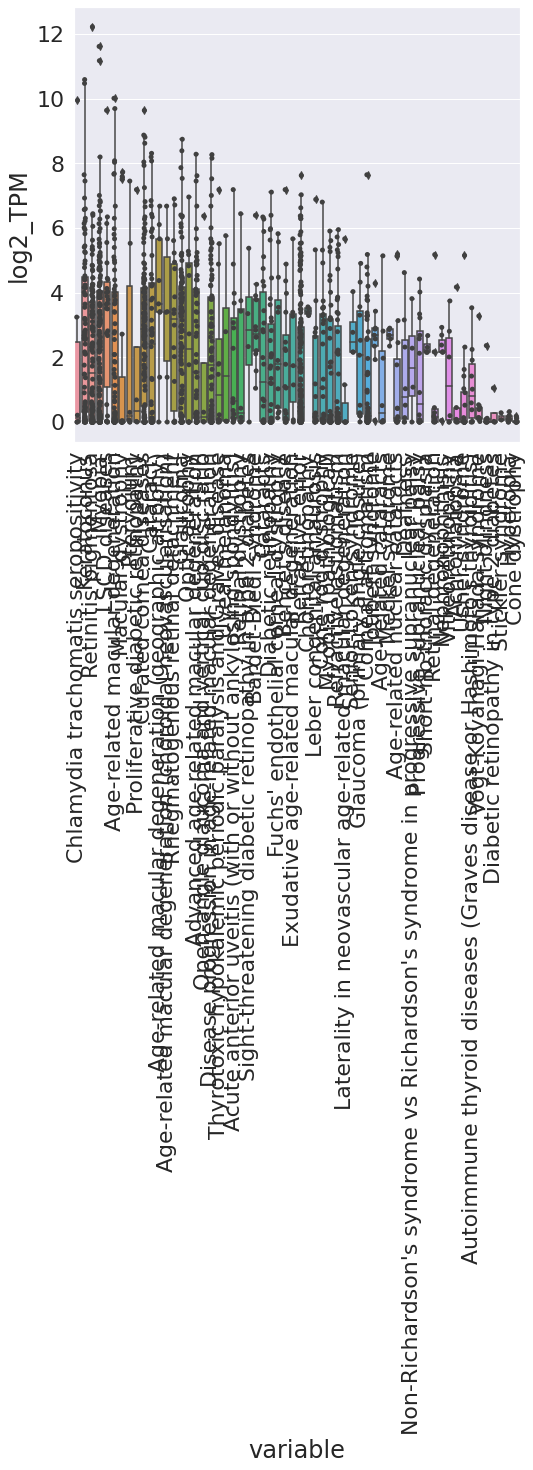

In [18]:
sns.set(rc={"figure.figsize": (8, 8)})
sns.set(font_scale=2)
ax = sns.boxplot(x="variable", y="log2_TPM", data=all_diseases_TPM)
ax = sns.stripplot(x="variable", y="log2_TPM", data=all_diseases_TPM, color=".25")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# lets grab the top 10 target genes from each enriched disease

In [19]:
top_n = 12

import statsmodels
from Python_scripts import distance_weight
from scipy.stats import mannwhitneyu
from scipy.stats import zscore
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

colnames2 = ['P63_1','P63_2','RUNX1_1','RUNX1_2','PAX6_1','PAX6_2','SMAD3_1','SMAD3_2','FOXC1_1','FOXC1_2','FOSL2_1','FOSL2_2','gene_name'] 

max_distance = 100000
weight = distance_weight(alpha=1e4, include_promoter=True, include_enhancer=True)
weight_dict = pd.Series(weight.weight.values, index=weight.dist).to_dict()
all_genes = pd.DataFrame(pd.read_table(TSS_regions_file, names = ['Chrom','ChromStart','ChromEnd','Strand','gene_name'])['gene_name'])
dotplot_genes = []
disease_table = []
sig_disease_table = []
TF_table = []
top_target_table = []
all_FDR = []
all_FDR_U = []
all_pval = []
all_pval_u = [] 
TF_sig = {}
disease_genes_with_peak = []
disease_genes_no_peak = []
all_genes_with_peak = []
all_genes_no_peak = []

for TF in ['FOXC1','RUNX1','SMAD3','P63','PAX6','FOSL2']:
#for TF in ['FOSL2']:
    print(TF)
    pval_table = []
    pval_U_table = []
    for disease in disease_gene_list.disease:
        #print(len(disease_expression_quantiles[disease]))
        gene_list = list(disease_gene_list[disease_gene_list.disease == disease].genes)[0].split(',')
        #only select peaks from the TF experiment
        TF_summits = region_reads[region_reads.location.isin(peak_per_TF[TF])]
        TF_summits = TF_summits.dropna()
        TF_summits = TF_summits[~TF_summits.distance.isna()]
        TF_summits = TF_summits[TF_summits.distance != 'NaN']
        TF_summits = TF_summits[TF_summits.distance < max_distance]

        # geomteric_testing:
        TF_summits = TF_summits.sort_values('distance', ascending = True)
        TF_summits = TF_summits.drop_duplicates('location') #only map peaks to the closest gene
        #add all gene TSS with no peak mapped to a value of 0
        missing_genenames = all_genes[~all_genes.gene_name.isin(TF_summits.gene_name)]
        for TF_chipseqsig in colnames:
            missing_genenames[TF_chipseqsig] = 0
        TF_summits = TF_summits.merge(missing_genenames, on = colnames2, how = 'outer')   
        TF_summits[colnames] = TF_summits[colnames] + 1
        TF_summits[colnames] = qnorm.quantile_normalize(np.log2(TF_summits[colnames]))
        TF_disease_genes = TF_summits[TF_summits.gene_name.isin(gene_list)]

        all_genes_chip = TF_summits.dropna().gene_name.unique()
        all_genes_nonchip = TF_summits[~TF_summits["gene_name"].isin(all_genes_chip)].gene_name.unique()

        #lets remove the chip regions close to genes with expression lower than the 10% quantile of the disease genes
        all_genes_chip = pd.DataFrame(all_genes_chip)
        #print(f'before filtering {len(all_genes_chip)}')
        all_genes_chip = all_genes_chip[all_genes_chip[0].isin((disease_expression_quantiles[disease]))]
        #print(f'after filtering {len(all_genes_chip)}')

        all_genes_nonchip = pd.DataFrame(all_genes_nonchip)
        #print(f'chipgenes before filtering {len(all_genes_nonchip)}')
        all_genes_nonchip = all_genes_nonchip[all_genes_nonchip[0].isin(disease_expression_quantiles[disease])]
        #print(f'chipgenes after filtering {len(all_genes_nonchip)}')

        disease_chip = TF_disease_genes.dropna().gene_name.unique()
        disease_nonchip = TF_disease_genes[~TF_disease_genes["gene_name"].isin(disease_chip)].gene_name.unique()

        table = np.array([[len(all_genes_chip), len(all_genes_nonchip)], [len(disease_chip), len(disease_nonchip)]])
        oddsr, p = fisher_exact(table)
        TF_table.append(TF)
        pval_table.append(p)
        #print(f'{disease} {p}')
        disease_genes_with_peak.append(int(len(disease_chip)))
        disease_genes_no_peak.append(int(len(disease_nonchip)))
        all_genes_with_peak.append(int(len(all_genes_chip)))
        all_genes_no_peak.append(int(len(all_genes_nonchip)))

        #lets also get the 'top target genes'
        TF_mean = pd.DataFrame(TF_summits[[f'{TF}_1',f'{TF}_2']].mean(axis = 1), columns = ['chipseqscore'])
        TF_mean['gene_name'] = TF_summits.gene_name
        TF_mean['distance'] = TF_summits.distance
        TF_mean["weight"] = TF_mean["distance"].map(weight_dict)
        TF_mean['chipseqscore'] = TF_mean['chipseqscore'].multiply(TF_mean["weight"], axis = 'index')
        #concatinate and distance weigh regions:
        TF_mean = TF_mean[['gene_name','chipseqscore']].groupby(['gene_name']).sum()
        TF_mean['gene_name'] = TF_mean.index
        TF_mean['zscore'] = zscore(TF_mean.chipseqscore)


        TF_mean_disease = TF_mean[TF_mean.gene_name.isin(gene_list)]
        U1, p_U = mannwhitneyu(TF_mean_disease.chipseqscore, 
                             TF_mean.chipseqscore,
                         alternative = 'greater')
        pval_U_table.append(p_U)
        top_disease_targets = " ".join(list(TF_mean_disease.sort_values(by = 'chipseqscore', ascending = False).head(top_n).gene_name))
        disease_table.append(disease)
        top_target_table.append(" ".join(list(TF_mean_disease.sort_values(by = 'chipseqscore', ascending = False).head(top_n).gene_name)))

    FDR_list = statsmodels.stats.multitest.fdrcorrection(pval_table)[1]
    FDR_U_list = statsmodels.stats.multitest.fdrcorrection(pval_U_table)[1]

    #FDR_list = pval_table
    all_FDR.extend(FDR_list)
    all_pval.extend(pval_table)
    all_FDR_U.extend(FDR_U_list)
    all_pval_u.extend(pval_U_table)

dotplot_genes_set = set(dotplot_genes)

output_table = pd.DataFrame(
    {'TF':TF_table,
     'disease': disease_table,
     'pval':all_pval,
     'FDR': all_FDR_U,
     'pval_u':all_pval_u,
     'FDR_manwithneyU': all_FDR,
     'disease_with_peak' : disease_genes_with_peak,
     'disease_no_peak' : disease_genes_no_peak,
     'allgenes_with_peak' : all_genes_with_peak,
     'allgenes_no_peak' : all_genes_no_peak,
     'top_targets (Approach JOS)': top_target_table,

    })

output_table.to_csv(
            f'{targetgene_dir}/{max_distance}_TSS_enriched_TF_table.tsv',
            sep=",",
            header=True,
            index=False,
)

FOXC1
RUNX1
SMAD3
P63
PAX6
FOSL2


In [21]:
#make a set of the top target genes
sig_enriched = output_table[((output_table.FDR_manwithneyU < 0.05) | (output_table.FDR < 0.05))]
sig_enriched.to_csv(
            f'{targetgene_dir}/significant_enriched.tsv',
            sep="\t",
            header=True,
            index=False,
        )
sig_enriched

,TF,disease,pval,FDR,pval_u,FDR_manwithneyU,disease_with_peak,disease_no_peak,allgenes_with_peak,allgenes_no_peak,top_targets (Approach JOS)
51,FOXC1,Glaucoma,0.118293,0.024216,8.071840e-04,1.000000,86,12,13422,3110,LTBP2 FBXO32 FOXC1 CAV1 SEMA3C GRHL2 MYOF SEMA...
58,FOXC1,Curated cornea diseases,0.036934,0.016326,2.721067e-04,1.000000,101,12,13207,2955,TGFBI WNT10A TACSTD2 LTBP2 JAG1 FOXC1 PTCH1 CP...
92,RUNX1,Bardet-Biedl syndrome,0.001612,0.994383,9.943832e-01,0.048351,2,10,6565,3948,BBS10 WDPCP ADIPOR1 BBIP1 BBS1 BBS12 BBS2 BBS4...
111,RUNX1,Glaucoma,0.000091,0.001029,1.714810e-05,0.005449,73,25,9079,7453,FBXO32 CAV1 GRHL2 MYOF ARHGEF12 SEMA3F SEMA3C ...
116,RUNX1,Keratoconus,0.043482,0.048758,2.020346e-03,0.372700,55,26,8748,6672,SLC47A2 SMAD3 CSNK1E ATP1B1 ALDH3A1 ITGA2 FOXO...
118,RUNX1,Curated cornea diseases,0.057206,0.048758,2.437877e-03,0.429043,73,40,8961,7201,COL7A1 TACSTD2 FGFR3 TGFBI WNT10A COL17A1 XPA ...
182,P63,Fuchs' endothelial corneal dystrophy,0.021339,0.020618,6.872632e-04,0.327619,8,3,4666,8523,SLC4A11 ATP1B1 LAMC1 KANK4 COL8A2 TCF4 ZEB1 PT...
231,P63,Glaucoma,0.000802,0.020618,4.059115e-04,0.048107,49,49,5527,11005,SEMA3F CFTR ME3 CAV2 SEMA3C PRDM5 RAPGEF5 OPTN...
256,PAX6,Refractive error,0.000219,0.010398,5.198944e-04,0.006562,105,42,9324,7208,CD55 LSM14A TJP2 MYOF ARID2 MYO5B RCBTB1 RASGE...
291,PAX6,Glaucoma,0.000008,0.000004,5.876797e-08,0.000473,77,21,9324,7208,LPP FBXO32 LTBP2 MYOF FOXC1 SEMA3C ZMIZ1 TES S...


In [185]:
#make a set of the top target genes
sig_enriched = output_table[((output_table.FDR_manwithneyU < 0.05) | (output_table.FDR < 0.05))]
sig_enriched.to_csv(
            f'{targetgene_dir}/significant_enriched.tsv',
            sep="\t",
            header=True,
            index=False,
        )


,TF,disease,pval,FDR,pval_u,FDR_manwithneyU,disease_with_peak,disease_no_peak,allgenes_with_peak,allgenes_no_peak,top_targets (Approach JOS)
51,FOXC1,Glaucoma,0.118293,0.024183,8.061115e-04,1.000000,86,12,13422,3110,LTBP2 FBXO32 FOXC1 CAV1 SEMA3C GRHL2 MYOF SEMA...
58,FOXC1,Curated cornea diseases,0.036934,0.016334,2.722284e-04,1.000000,101,12,13207,2955,TGFBI WNT10A TACSTD2 LTBP2 JAG1 FOXC1 PTCH1 CP...
92,RUNX1,Bardet-Biedl syndrome,0.001612,0.994385,9.943850e-01,0.048351,2,10,6565,3948,BBS10 WDPCP ADIPOR1 BBIP1 BBS1 BBS12 BBS2 BBS4...
111,RUNX1,Glaucoma,0.000091,0.000980,1.632914e-05,0.005449,73,25,9079,7453,FBXO32 CAV1 GRHL2 MYOF ARHGEF12 SEMA3F SEMA3C ...
116,RUNX1,Keratoconus,0.043482,0.048653,2.009766e-03,0.372700,55,26,8748,6672,SLC47A2 SMAD3 CSNK1E ATP1B1 ALDH3A1 ITGA2 FOXO...
118,RUNX1,Curated cornea diseases,0.057206,0.048653,2.432634e-03,0.429043,73,40,8961,7201,COL7A1 TACSTD2 FGFR3 TGFBI WNT10A COL17A1 XPA ...
182,P63,Fuchs' endothelial corneal dystrophy,0.021339,0.020484,6.828145e-04,0.327619,8,3,4666,8523,SLC4A11 ATP1B1 LAMC1 KANK4 COL8A2 TCF4 ZEB1 PT...
231,P63,Glaucoma,0.000802,0.020484,4.051601e-04,0.048107,49,49,5527,11005,SEMA3F CFTR ME3 CAV2 SEMA3C PRDM5 RAPGEF5 OPTN...
256,PAX6,Refractive error,0.000219,0.010344,5.171888e-04,0.006562,105,42,9324,7208,CD55 LSM14A TJP2 MYOF ARID2 MYO5B RCBTB1 RASGE...
291,PAX6,Glaucoma,0.000008,0.000004,5.863074e-08,0.000473,77,21,9324,7208,LPP FBXO32 LTBP2 MYOF FOXC1 SEMA3C ZMIZ1 TES S...


In [206]:
sig_enriched_figure = output_table[((output_table.FDR < 0.05))]
print(len(sig_enriched_figure))
sig_enriched_figure

15


,TF,disease,pval,FDR,pval_u,FDR_manwithneyU,disease_with_peak,disease_no_peak,allgenes_with_peak,allgenes_no_peak,top_targets (Approach JOS)
51,FOXC1,Glaucoma,0.118293,0.024183,8.061115e-04,1.000000,86,12,13422,3110,LTBP2 FBXO32 FOXC1 CAV1 SEMA3C GRHL2 MYOF SEMA...
58,FOXC1,Curated cornea diseases,0.036934,0.016334,2.722284e-04,1.000000,101,12,13207,2955,TGFBI WNT10A TACSTD2 LTBP2 JAG1 FOXC1 PTCH1 CP...
111,RUNX1,Glaucoma,0.000091,0.000980,1.632914e-05,0.005449,73,25,9079,7453,FBXO32 CAV1 GRHL2 MYOF ARHGEF12 SEMA3F SEMA3C ...
116,RUNX1,Keratoconus,0.043482,0.048653,2.009766e-03,0.372700,55,26,8748,6672,SLC47A2 SMAD3 CSNK1E ATP1B1 ALDH3A1 ITGA2 FOXO...
118,RUNX1,Curated cornea diseases,0.057206,0.048653,2.432634e-03,0.429043,73,40,8961,7201,COL7A1 TACSTD2 FGFR3 TGFBI WNT10A COL17A1 XPA ...
182,P63,Fuchs' endothelial corneal dystrophy,0.021339,0.020484,6.828145e-04,0.327619,8,3,4666,8523,SLC4A11 ATP1B1 LAMC1 KANK4 COL8A2 TCF4 ZEB1 PT...
231,P63,Glaucoma,0.000802,0.020484,4.051601e-04,0.048107,49,49,5527,11005,SEMA3F CFTR ME3 CAV2 SEMA3C PRDM5 RAPGEF5 OPTN...
256,PAX6,Refractive error,0.000219,0.010344,5.171888e-04,0.006562,105,42,9324,7208,CD55 LSM14A TJP2 MYOF ARID2 MYO5B RCBTB1 RASGE...
291,PAX6,Glaucoma,0.000008,0.000004,5.863074e-08,0.000473,77,21,9324,7208,LPP FBXO32 LTBP2 MYOF FOXC1 SEMA3C ZMIZ1 TES S...
298,PAX6,Curated cornea diseases,0.002969,0.003806,1.268617e-04,0.059380,80,33,9177,6985,TACSTD2 TGFBI LTBP2 CPAMD8 FOXC1 CYP1B1 PXDN C...


In [22]:
sig_enriched_figure = output_table[((output_table.FDR < 0.05))]
print(len(sig_enriched_figure))
sig_enriched_figure

17


,TF,disease,pval,FDR,pval_u,FDR_manwithneyU,disease_with_peak,disease_no_peak,allgenes_with_peak,allgenes_no_peak,top_targets (Approach JOS)
51,FOXC1,Glaucoma,0.118293,0.024216,8.071840e-04,1.000000,86,12,13422,3110,LTBP2 FBXO32 FOXC1 CAV1 SEMA3C GRHL2 MYOF SEMA...
58,FOXC1,Curated cornea diseases,0.036934,0.016326,2.721067e-04,1.000000,101,12,13207,2955,TGFBI WNT10A TACSTD2 LTBP2 JAG1 FOXC1 PTCH1 CP...
111,RUNX1,Glaucoma,0.000091,0.001029,1.714810e-05,0.005449,73,25,9079,7453,FBXO32 CAV1 GRHL2 MYOF ARHGEF12 SEMA3F SEMA3C ...
116,RUNX1,Keratoconus,0.043482,0.048758,2.020346e-03,0.372700,55,26,8748,6672,SLC47A2 SMAD3 CSNK1E ATP1B1 ALDH3A1 ITGA2 FOXO...
118,RUNX1,Curated cornea diseases,0.057206,0.048758,2.437877e-03,0.429043,73,40,8961,7201,COL7A1 TACSTD2 FGFR3 TGFBI WNT10A COL17A1 XPA ...
182,P63,Fuchs' endothelial corneal dystrophy,0.021339,0.020618,6.872632e-04,0.327619,8,3,4666,8523,SLC4A11 ATP1B1 LAMC1 KANK4 COL8A2 TCF4 ZEB1 PT...
231,P63,Glaucoma,0.000802,0.020618,4.059115e-04,0.048107,49,49,5527,11005,SEMA3F CFTR ME3 CAV2 SEMA3C PRDM5 RAPGEF5 OPTN...
256,PAX6,Refractive error,0.000219,0.010398,5.198944e-04,0.006562,105,42,9324,7208,CD55 LSM14A TJP2 MYOF ARID2 MYO5B RCBTB1 RASGE...
291,PAX6,Glaucoma,0.000008,0.000004,5.876797e-08,0.000473,77,21,9324,7208,LPP FBXO32 LTBP2 MYOF FOXC1 SEMA3C ZMIZ1 TES S...
298,PAX6,Curated cornea diseases,0.002969,0.003814,1.271303e-04,0.059380,80,33,9177,6985,TACSTD2 TGFBI LTBP2 CPAMD8 FOXC1 CYP1B1 PXDN G...


In [38]:
from scipy.stats import zscore

topn = 5
#get the top target genes of the all significant terms
#target_genes = list(sig_enriched['top_targets (Approach JOS)'].apply(lambda x: x[1:-1].split(' ')))
target_genes = list(sig_enriched_figure['top_targets (Approach JOS)'].apply(lambda x: x[1:-1].split(' ')))

target_genes = [",".join(item[0:topn]) for item in target_genes]
dotplot_genes_set = set((",".join(target_genes)).split(','))
dotplot_df = pd.DataFrame(dotplot_genes_set)
dotplot_df.columns = {'gene_name'}

concat_target_gene_peaks = True

#lets loop over all TF values once more to get the values for the dotplot genes for each TF
for TF in ['FOXC1','RUNX1','SMAD3','P63','PAX6','FOSL2']:
    TF_summits = region_reads[region_reads.location.isin(peak_per_TF[TF])]
    TF_summits[colnames] = TF_summits[colnames] + 1
    TF_summits[colnames] = qnorm.quantile_normalize(np.log10(TF_summits[colnames]))
    TF_summits[colnames] = TF_summits[colnames].apply(zscore)

    #TF_summits[colnames] = np.log2(TF_summits[colnames])
    #drop regions not linked to genes:
    TF_summits = TF_summits.dropna()

    TF_mean = pd.DataFrame(TF_summits[[f'{TF}_1',f'{TF}_2']].mean(axis = 1), columns = ['chipseqscore'])
    TF_mean['gene_name'] = TF_summits.gene_name

    if concat_target_gene_peaks:
        TF_mean['distance'] = TF_summits.distance
        TF_mean["weight"] = TF_mean["distance"].map(weight_dict)
        TF_mean['chipseqscore'] = TF_mean['chipseqscore'].multiply(TF_mean["weight"], axis = 'index')
        #concatinate and distance weigh regions:
        TF_mean = TF_mean.groupby('gene_name')['chipseqscore'].agg(['sum','count'])
        TF_mean.columns = ['chipseqscore','npeaks']   
        #TF_mean['gene_name'] = TF_mean.index
        TF_mean=TF_mean.reset_index()
        TF_mean['npeaks_score'] = TF_mean['npeaks'].astype(str) + '_' + TF_mean['chipseqscore'].astype(str)

    dotplot_int = TF_mean[TF_mean[['gene_name','npeaks_score']].gene_name.isin(dotplot_df.gene_name)]
    dotplot_int = dotplot_int[['gene_name','npeaks_score']]
    dotplot_int.columns = ['gene_name',f'{TF}']
    dotplot_df = dotplot_df.merge(dotplot_int, left_on = 'gene_name', right_on = 'gene_name', how = 'outer')
    
dotplot_df = pd.melt(dotplot_df, id_vars=['gene_name'])
dotplot_df[['npeaks', 'chip_intensity']] = dotplot_df['value'].str.split('_', 1, expand=True)
dotplot_df = dotplot_df.drop(['value'], axis = 1)

## output the matrix with intensity and peaks to make a complex heatmap dotplot
dotplot_df.to_csv(
            f'{targetgene_dir}/chipseq_int_npeak_matrix.tsv',
            sep="\t",
            header=True,
            index=False,
        )

In [39]:
set(dotplot_df['gene_name'])

{'ACSTD2',
 'ALDH3A1',
 'AM126A',
 'ANTXR2',
 'ARHGEF12',
 'ARID2',
 'ATP1B1',
 'AV1',
 'BFSP1',
 'BXO32',
 'CAV1',
 'CAV2',
 'CD55',
 'CELSR1',
 'CFTR',
 'CLU',
 'COL12A1',
 'COL7A1',
 'COL8A2',
 'CPAMD8',
 'CRYG',
 'CSNK1E',
 'CTPS1',
 'D55',
 'DNMBP',
 'DOP1B',
 'EMA3F',
 'EPHA2',
 'FBXO32',
 'FGFR3',
 'FOXC1',
 'GFBI',
 'GJA1',
 'GMDS',
 'GRHL2',
 'JAG1',
 'KANK4',
 'KAP6',
 'LAMC1',
 'LC47A2',
 'LC4A11',
 'LF6',
 'LSM14A',
 'LTBP2',
 'ME3',
 'MYOF',
 'OL17A1',
 'OL7A1',
 'POC5',
 'PP',
 'RAPGEF5',
 'SEMA3C',
 'SMAD3',
 'SRFBP1',
 'TACSTD2',
 'TBP2',
 'TGA2',
 'TGFBI',
 'TJP2',
 'TRAPPC9',
 'VIM',
 'WNT10A',
 'XPA',
 'YOF'}

In [120]:
#lets also make a graph to indicate the presence of a gene in the disease gene list

In [40]:
sig_diseases = set(sig_enriched['disease'])
sig_diseases = disease_gene_list[disease_gene_list['disease'].isin(sig_diseases)]

In [41]:
for i in range(0,len(sig_diseases)):
    print(i)
    dotplot_df[sig_diseases.iloc[i]['disease']] = dotplot_df['gene_name'].isin(list(sig_diseases.iloc[i][['genes']])[0].split(','))

0
1
2
3
4
5
6
7
8


In [42]:
dotplot_df = dotplot_df.dropna()
dotplot_df.to_csv(
            f'{targetgene_dir}/chipseq_int_npeak_matrix_annotated.tsv',
            sep="\t",
            header=True,
            index=False,
        )

# Vizualize the loci of all the top disease gene targeted:

In [29]:
viz_genes = list(set(dotplot_df.gene_name))
viz_genes.append('KRT12')
viz_genes.append('MAF')
viz_genes.append('CLDN1')
viz_genes.append('JAG1')
viz_genes.append('TGFBI')


gene_list = viz_genes
TSS_file = "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/TSS_regions_sorted.bed"
locus_length = 50000
#locus_length = 20000

TSS_table = pd.read_table(
    f"{TSS_file}",
    index_col=None,
    names=[
        "chr_TSS",
        "start_TSS",
        "end_TSS",
        "strand",
        "gene_name",
    ],
)

TSS_region = TSS_table[TSS_table.gene_name.isin(gene_list)]
#get TSS region length of the file and subtract it
TSSlen = TSS_region.end_TSS - TSS_region.start_TSS

# #remove length TSS region of original file
TSS_region.start_TSS = TSS_region.start_TSS + (TSSlen/2)
TSS_region.end_TSS = TSS_region.end_TSS - (TSSlen/2)

# #add locus length 
TSS_region.start_TSS = TSS_region.start_TSS - (locus_length/2)
TSS_region.end_TSS = TSS_region.end_TSS + (locus_length/2)

TSS_region.start_TSS = TSS_region.start_TSS.astype(int)
TSS_region.end_TSS = TSS_region.end_TSS.astype(int)

TSS_region.to_csv(
            f'{targetgene_dir}/bwfiles/vizualized_loci_diseases.bed',
            #f'{targetgene_dir}/bwfiles/vizualized_loci.bed',
            sep="\t",
            header=False,
            index=False,
        )

#make a directory to output the pygenometracks figures
Path(f"{targetgene_dir}/bwfiles/disease_genes").mkdir(parents=True, exist_ok=True)


In [30]:
# #In the pygenometracks env run:
# # cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# # pyGenomeTracks --tracks tracks_chipseq.ini --BED vizualized_loci_diseases.bed --outFileName disease_genes/dotplot.pdf --width 14 --dpi 300
# # pyGenomeTracks --tracks pyGenomeTracks --tracks tracks_chipseq.ini --BED vizualized_loci_diseases.bed --outFileName disease_genes/dotplot.pdf --width 14 --dpi 300 --BED vizualized_loci_diseases.bed --outFileName disease_genes/dotplot.pdf --width 14 --dpi 300

#lets rename the files to their respective genename instead of chrom regions
for index, data in TSS_region[['gene_name', 'chr_TSS','start_TSS','end_TSS']].iterrows():
    filename = f"{targetgene_dir}bwfiles/disease_genes/dotplot_{data[1]}-{data[2]}-{data[3]}.pdf"
    newname = f'{targetgene_dir}bwfiles/disease_genes/{data[0]}_TSS.pdf'
    try:
        #print(filename)
        os.rename(filename, newname)
    except OSError as e:
        print(e)

In [ ]:
TSS_region

# lets next vizualize the location of TF motifs acros TSS regions

In [ ]:
curated_status = 'all_motifs'
#lets first filter the motif database to only contain motifs of the TFs of interest:
motif2scan = list(TF_df.Motif.unique())

# filter pfm database
pfm_file = open("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/gimme.vertebrate.v5.0.pfm", "r")
all_motifs_dict = {}
pwm_list = []
new_motif = ""
for line in pfm_file:
    if line.startswith(">"):
        if new_motif != "":
            all_motifs_dict[new_motif] = pwm_list
            pwm_list = []
        new_motif = line.strip()
        new_motif = new_motif.strip(">")
    else:
        pwm_list.append([line.strip()])
pfm_file.close()

# only diff TFs
diff_motifs_dict = {
    k: v for k, v in all_motifs_dict.items() if k in (list(motif2scan))
}
diff_pfm_file = open(
    f"{targetgene_dir}/{curated_status}_of_interest.pfm",
    "w",
)
for TF, pwm in diff_motifs_dict.items():
    diff_pfm_file.write(f">{TF}\n")
    for line in pwm:
        diff_pfm_file.write(f'{"".join(line)}\n')
diff_pfm_file.close()

#only scan ATAC peaks that fall within 50kb distance
TSS_filter_distance = 50000
TSS_20kb_elements = motifs_df[motifs_df['distance'] != 'NaN']
TSS_20kb_elements = TSS_20kb_elements[TSS_20kb_elements['distance'].astype(int) < TSS_filter_distance]
TSS_20kb_elements = TSS_20kb_elements.drop_duplicates(subset = 'Unnamed: 0')

#filter all ATAC peaks that fall outside the filter distance
TSS_20kb_elements['Unnamed: 0'].to_csv(
            f"{targetgene_dir}/{TSS_filter_distance}_gene_TSS.txt",
            header=False,
            index=False,
        )
#also output them as a bedfile
TSS_20kb_elements[['chr_TSS']] = TSS_20kb_elements[['chr_TSS']].astype(int) 
TSS_20kb_elements[['start_TSS']] = TSS_20kb_elements[['start_TSS']].astype(int) -9000
TSS_20kb_elements[['end_TSS']] = TSS_20kb_elements[['end_TSS']].astype(int) + 9000

TSS_20kb_elements[['chr_TSS','start_TSS','end_TSS']].drop_duplicates().to_csv(
            f"{targetgene_dir}/{TSS_filter_distance}_gene_TSS.bed",
            sep = '\t',
            header=False,
            index=False,
        )

TSS_20kb_elements_filtered = TSS_20kb_elements[['chr_TSS','start_TSS','end_TSS','gene_name']].drop_duplicates()
disease_gene_TSS_regions = TSS_20kb_elements_filtered[TSS_20kb_elements_filtered.gene_name.isin(disease_literature.Gene)]

disease_gene_TSS_regions[['chr_TSS','start_TSS','end_TSS','gene_name']].drop_duplicates().to_csv(
            f"{targetgene_dir}/bwfiles/{TSS_filter_distance}_gene_TSS.bed",
            sep = '\t',
            header=False,
            index=False,
        )

print('running gimme scan')
#Run gimme scan on all TSS regions of all genes:

sp.check_call(f'gimme scan '
              f'-b --gc '
              '-f 0.1 '
              f'-N 12 '
              f'-g /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/hg38/hg38.fa '
              f'{targetgene_dir}/{TSS_filter_distance}_gene_TSS.txt '
              f'-p {targetgene_dir}/{curated_status}_of_interest.pfm '
              f'> {targetgene_dir}/{TSS_filter_distance}_{curated_status}_gene_scanning.bed '
              f'2> {targetgene_dir}/{TSS_filter_distance}_{curated_status}_gene_scanning.log',shell = True)


In [ ]:
#lets rename all the motifs to TFs 
TSS_filter_distance = 50000

TF_bed_file = pd.read_table(f"{targetgene_dir}/{TSS_filter_distance}_{curated_status}_gene_scanning.bed",
                            sep="\t",
                            comment="#",
                            names = ['Chrom','ChromStart','ChromEnd','Motif','log2score','Strand'])

#TF_motif_file vervangen met motifs_linked
motif2factor = motifs2factors_filtered2[motifs2factors_filtered2.Factor.isin(list(TF_df.Factor.unique()))]

TF_bed_file = TF_bed_file.merge(motif2factor, on = 'Motif')
TF_bed_file = TF_bed_file.drop_duplicates(subset=['Chrom', "ChromStart",'ChromEnd','Motif','Factor'])
TF_bed_file['location'] = TF_bed_file['Chrom'].astype(str) + ":" + TF_bed_file['ChromStart'].astype(str) + "-" + TF_bed_file['ChromEnd'].astype(str)
TF_bed_file_filtered = TF_bed_file[TF_bed_file.Factor.isin(Cherry_picked_TFs)]

print('merging multiple TFs mapped to motif (takes like 60 min)')
TF_bed_file_filtered['all_TFS'] = TF_bed_file_filtered[['location','Factor']].groupby('location').transform(lambda x: ','.join(x))
TF_bed_file_filtered = TF_bed_file_filtered[['Chrom','ChromStart','ChromEnd','all_TFS','Motif','log2score','Strand']].drop_duplicates()
TF_bed_file_positive = TF_bed_file_filtered[TF_bed_file_filtered['log2score'] > 0]
TF_bed_file_positive['log2score_int'] = TF_bed_file_positive['log2score'].astype(int)
TF_bed_file_positive[['Chrom','ChromStart','ChromEnd','all_TFS','log2score_int','Strand']].to_csv(
            f"{targetgene_dir}/TF_motifs.bed",
            sep = '\t',
            header=False,
            index=False,
        )

In [ ]:
#Bed to bigbed
# sort the bedfile and make a bigbed file for vizualization
sp.check_call(
    f"bedSort "
    f"{targetgene_dir}/TF_motifs_{curated_status}.bed "
    f"{targetgene_dir}/TF_motifs_{curated_status}_sorted.bed ",
    shell=True,
)
print('converting to bigbed')
sp.check_call(
    f"bedToBigBed "
    f"{targetgene_dir}TF_motifs_{curated_status}_sorted.bed "
    f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/hg38/hg38.fa.sizes "
    f"{targetgene_dir}TF_motifs_{curated_status}.bigbed ",
    shell=True,
)

In [ ]:
#In the pygenometracks env run:
# cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# pyGenomeTracks --tracks tracks.ini --BED disesease_list_regions.bed --outFileName disease_gene.pdf --width 38 --dpi 300
# pyGenomeTracks --tracks tracks.ini --BED 50000_gene_TSS.bed --outFileName disease_gene.pdf --width 38 --dpi 300

#lets rename the files to their respective genename instead of chrom regions


In [ ]:
#In the pygenometracks env run:
# cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# pyGenomeTracks --tracks tracks.ini --BED disesease_list_regions.bed --outFileName disease_gene.pdf --width 38 --dpi 300
# pyGenomeTracks --tracks tracks.ini --BED 50000_gene_TSS.bed --outFileName disease_gene.pdf --width 38 --dpi 300

#lets rename the files to their respective genename instead of chrom regions

for index, data in disease_gene_TSS_regions[['gene_name', 'chr_TSS','start_TSS','end_TSS']].iterrows():
    filename = f"{targetgene_dir}bwfiles/disease_gene_{data[1]}-{data[2]}-{data[3]}.pdf"
    newname = f'{targetgene_dir}bwfiles/{data[0]}_TSS.pdf'
    try:
        print(filename)
        os.rename(filename, newname)
    except OSError as e:
        print(data[0])

In [ ]:
#lets rename all the motifs to TFs 
TSS_filter_distance = 25000

TF_bed_file = pd.read_table(f"{targetgene_dir}/{TSS_filter_distance}_{curated_status}_gene_scanning.bed",
                            sep="\t",
                            comment="#",
                            names = ['Chrom','ChromStart','ChromEnd','Motif','log2score','Strand'])

#TF_motif_file vervangen met motifs_linked
factor2motif = motifs_linked[["Curated"]]
factor2motif_reset=factor2motif.reset_index()
factor2motif = factor2motif_reset.drop('Curated', axis = 1)

TF_bed_file = TF_bed_file.merge(factor2motif, on = 'Motif')
TF_bed_file = TF_bed_file.drop_duplicates(subset=['Chrom', "ChromStart",'ChromEnd','Motif','Factor'])
TF_bed_file['location'] = TF_bed_file['Chrom'].astype(str) + ":" + TF_bed_file['ChromStart'].astype(str) + "-" + TF_bed_file['ChromEnd'].astype(str)
TF_bed_file['all_TFS'] = TF_bed_file[['location','Factor']].groupby('location').transform(lambda x: ','.join(x))
TF_bed_file = TF_bed_file[['Chrom','ChromStart','ChromEnd','all_TFS','Motif','log2score','Strand']].drop_duplicates()
TF_bed_file[['Chrom','ChromStart','ChromEnd','all_TFS','log2score','Strand']].to_csv(
            f"{targetgene_dir}/TF_motifs_{curated_status}.bed",
            sep = '\t',
            header=False,
            index=False,
        )

In [ ]:
#Bed to bigbed

# sort the bedfile and make a bigbed file for vizualization
sp.check_call(
    f"bedSort "
    f"{targetgene_dir}/TF_motifs_{curated_status}.bed "
    f"{targetgene_dir}/TF_motifs_{curated_status}_sorted.bed ",
    shell=True,
)
print('converting to bigbed')
sp.check_call(
    f"bedToBigBed "
    f"{targetgene_dir}TF_motifs_{curated_status}_sorted.bed "
    f"/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/hg38/hg38.fa.sizes "
    f"{targetgene_dir}TF_motifs_{curated_status}.bigbed ",
    shell=True,
)


In [ ]:
#In the pygenometracks env run:
# cd /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Ananse_test_data/analysis/peakpred_V10/targetgenes/bwfiles/
# pyGenomeTracks --tracks tracks.ini --BED disesease_list_regions.bed --outFileName disease_gene.pdf --width 38 --dpi 300

#lets rename the files to their respective genename instead of chrom regions

for region in all_TSS_windows:
    region = region.split('\t')
    print(region)
    filename = f"{targetgene_dir}bwfiles/disease_gene_{region[0]}-{region[1]}-{region[2]}.pdf"
    newname = f'{targetgene_dir}bwfiles/{region[3]}_TSS.pdf'
    try:
        os.rename(filename, newname)
    except OSError as e:
        print(region[3])
#os.rename(file, destination)

In [ ]:
# sns.set(rc={"figure.figsize": (50, 20)})
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.table as tbl
# def set_pad_for_column(col, pad=0.1):
#     cells = table.get_celld()
#     column = [cell for cell in table.get_celld() if cell[1] == col]
#     for cell in column:
#         cells[cell].PAD = pad
        
# cmap_reds = plt.get_cmap('Reds')
# num_colors = 15
# colors = ['white', 'white'] + [cmap_reds(i / num_colors) for i in range(2, num_colors)]
# cmap = LinearSegmentedColormap.from_list('', colors, num_colors)
# cmap_reds = LinearSegmentedColormap.from_list('',  [cmap_reds(i / num_colors) for i in range(2, num_colors)], num_colors)
# pdf_pages = PdfPages(f'{targetgene_dir}disease_TF_ananse_plot.pdf')

# for disease in zip(filtered_disease_list.index):
# #for disease in ["Dulce_list","Glaucoma"]:
#     name = f"{disease[0]}_-10logfdr"
#     if name in list(working_matrix.columns):
#         if  working_matrix[f'{name}'].max() > 1.3:
#             print(name)
#             print(working_matrix[f'{name}'].max())
#             fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 15]})
#             sns.scatterplot(
#             x="sumScaled_ESC2KC",
#             y="sumScaled_ESC2LSC",
#             data=working_matrix,
#             alpha=0.8,
#             vmin = 1.3,
#             vmax= 2.2,
#             hue_norm=(1.3,working_matrix[[f'{name}']].max()),
#             hue = working_matrix[f'{name}'],
#             palette = cmap,
#             sizes=(100, 600),
#             size = f"{name}",
#             ax = axes[0]
#             )

#             #add text labeling
#             TF_highlighed = working_matrix[working_matrix[f'{name}'] > 1.3]
#             #TF_highlighed = TF_highlighed.reset_index().drop('index',axis =1)

#             y_text=TF_highlighed.sumScaled_ESC2LSC
#             x_text=TF_highlighed.sumScaled_ESC2KC
#             texts = [axes[0].text(x_text[i],
#                               y_text[i],
#                               TF_highlighed.factor[i],
#                               fontsize=12,
#                              ) 
#                      for i in range(len(TF_highlighed.sumScaled_ESC2LSC))]
#             #str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r', lw=2)))
#             axes[0].axline((0, 0), (1, 1), linewidth=4, color='r', linestyle = '--', in_layout = False)
#             axes[0].set(title=name)
#             #color bar
#             norm = plt.Normalize(1.33,working_matrix[f'{name}'].max(), clip = True)
#             sm = plt.cm.ScalarMappable(cmap=cmap_reds, norm=norm)
#             sm.set_array([])


#             # Remove the legend and add a colorbar
#             axes[0].get_legend().remove()
#             axes[0].figure.colorbar(sm, orientation = 'horizontal', label = 'log-10 FDR')
#             #cb = plt.colorbar(im)
#             #plot a table with the top TF and the top disease target gens of each top TF
#             axes[1].patch.set_visible(False)
#             axes[1].axis('off')
#             axes[1].axis('tight')

#             top_TF = TF_highlighed.sort_values(by = f'{name}', axis = 0, ascending = False)
#             top_TF = top_TF[['factor',f'{name}',f'{disease[0]}_motif_linked',f'{disease[0]}_top_targets',f'{disease[0]}_ngeneset',f'{disease[0]}_ntargets']]
#             #top_TF = top_TF.reset_index().drop('index',axis =1)
#             top_TF.rename(columns = {f'{name}':'log-10 FDR', f'{disease[0]}_top_targets':'top_targets',f'{disease[0]}_ngeneset':'ngeneset',f'{disease[0]}_ntargets':'targets'}, inplace = True)
#             top_TF[['log-10 FDR']] = top_TF[['log-10 FDR']].round(3)
#             top_TF = top_TF[['factor',f'{disease[0]}_motif_linked', 'log-10 FDR', 'ngeneset', 'targets', 'top_targets']]

#             table = tbl.table(
#                 ax = axes[1],
#                 cellText=top_TF.values,
#                 colLabels=top_TF.columns,
#                 cellLoc = 'left',
#                 colLoc = 'left',
#                 loc = 'left',
#                 colColours = ['lightblue','lightblue','lightblue','lightblue','lightblue','lightblue'],
#                 bbox=[0, 0, 1, 1])
#             #)

#             table.auto_set_font_size(False)
#             table.set_fontsize(8)
#             set_pad_for_column(col=[1,2,3,4,5,6], pad=0.01) 
            
#             #set_pad_for_column(col=3, pad=0.01) 

#             table.auto_set_column_width(col=range(len(top_TF.columns))) # Provide integer list of columns to adjust
#             axes[1].add_table(table)
#             pdf_pages.savefig(fig)

# pdf_pages.close()

In [ ]:
TF_bed_file

In [ ]:
gene_name = 'CD63'
gtf_file = TSS_regions_file

gene_TSS_regions = pd.read_table(TSS_regions_file,sep = '\t', comment = '#', names = ['Chrom','ChromStart',"ChromEnd",'strand','Gene'])
#TSS_location = list(gene_TSS_regions[gene_TSS_regions.Gene == gene_name].index)
TSS_location = gene_TSS_regions[gene_TSS_regions.Gene == gene_name]
TSS_location.ChromStart = TSS_location.ChromStart - 50000
TSS_location.ChromEnd = TSS_location.ChromEnd + 50000

#get all the regions mapped to PAX6
gene_TSS_ATAC_summits = motifs_df[motifs_df['gene_name']==gene_name][['Unnamed: 0']]
#output these regions for motif scanning:
gene_TSS_ATAC_summits.to_csv(
            f"{targetgene_dir}/PAX6TSS_ATAC_peaks.txt",
            header=False,
            index=False,
        )
sp.check_call(f'gimme scan '
              f'-b --gc -f 0.2 '
              f'-N 12 '
              f'-g /ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/genomepy_genomes/hg38/hg38.fa '
              f'{targetgene_dir}/PAX6TSS_ATAC_peaks.txt '
              f'> {targetgene_dir}/gene_scanning.txt '
              f'2> {targetgene_dir}/gene_scanning.log',shell = True)



In [ ]:
TSS_location

In [ ]:
TFs_sig = ["EGR1", 
           "VDR",
"NR2F2",
"RXRA",
"ZNF148",
"PPARD",
"CEBPD",
"OTX1",
"CEBPG",
"PRDM1",
"NR3C1",
"CEBPB",
"TEF",
"KLF6",
"NFE2L2",
"HOXA9",
"MEIS1",
"HIVEP2",
"EHF",
"GATA3"]


motifs_identified = pd.read_table(f'{targetgene_dir}/gene_scanning.txt',sep = '\t', comment = '#', names = ['Chrom','ChromStart',"ChromEnd",'motif','pval','strand'])
motifs_identified['TF'] = ""
for TF in TFs_sig:
    all_Factor_motifs = list(motifs2factors_curated[motifs2factors_curated.Factor == TF].Motif.unique())
    motifs_identified.loc[motifs_identified.motif.isin(all_Factor_motifs),'TF'] = TF
    motifs_identified.loc[motifs_identified["motif"].isin(all_Factor_motifs), "TF"] = TF

TF_binding_identified = motifs_identified[motifs_identified['TF'] != ""]

In [ ]:
TF_binding_identified[['Chrom','ChromStart','ChromEnd','TF']].to_csv(
            f"{targetgene_dir}/TF_binding.bed",
            sep = '\t',
            header=False,
            index=False,
        )

In [ ]:
TF_binding_identified.TF.value_counts()

In [ ]:
def merge_bw_replicas(input_bw, genome_path_size, output_bw):
    """
    input_bw: list of bw replica's to merge
    genome_path_size: file of chrom sizes of a genome
    ouput_bw: location of the output bw file
    """
    input_bw = " ".join(input_bw)
    print("merging to bedgraph")
    sp.check_call(
        f"bigWigMerge {input_bw} {output_bw}.tmp",
        shell=True,
    )
    print("sorting bedgraph")
    sp.check_call(
        f"bedSort {output_bw}.tmp {output_bw}.bedgraph",
        shell=True,
    )
    print(" bedgraph 2 bw")
    sp.check_call(
        f"bedGraphToBigWig {output_bw}.bedgraph {genome_path_size} {output_bw} ",
        shell=True,
    )
    print("removing bedgraph")
    sp.check_call(f"rm -r {output_bw}.tmp", shell=True)
    sp.check_call(f"rm -r {output_bw}.bedgraph", shell=True)

In [ ]:
#Merge the replica bigwigs for vizualization purpose:
KC_RNASeq_track = f"{targetgene_dir}/bwfiles/RNA_BAM_KC_merged.bw"
if os.path.exists(KC_RNASeq_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/HKCday01RNASeq.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/HKCday02RNASeq.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/PKC19RNA1.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/PKC19RNA2.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', KC_RNASeq_track)
    
    #Merge the replica bigwigs for vizualization purpose:
LSC_RNASeq_track = f"{targetgene_dir}/bwfiles/RNA_BAM_LSC_merged.bw"
if os.path.exists(LSC_RNASeq_track) == False:
    input_bw_merge = [
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/LSCouyang1.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/LSCouyang2.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/LSCRNA1.bigWig",
        "/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/RNAseq_rerun/results/trackhub/hg38/LSCRNA2.bigWig"
    ]
    merge_bw_replicas(input_bw_merge, '/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/Epi_fate_specifiers/genomes/GRCh38.p13/GRCh38.p13.fa.sizes', LSC_RNASeq_track)